In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from scipy.stats import zscore
import xgboost as xgb
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,classification_report,f1_score,make_scorer,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV, GridSearchCV, train_test_split,cross_val_score
from bayes_opt import BayesianOptimization
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
import seaborn as sns
from datetime import datetime

In [3]:
# Just to ignore the warnings
warnings.filterwarnings('ignore')

# Max columns
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.expand_frame_repr', False)

# Importing the data

In [4]:
# train and test set
train = pd.read_csv("C:\\Users\\josha\Downloads\\african-credit-scoring-challenge20241203-14702-1yayxml\\Train.csv")
test = pd.read_csv("C:\\Users\\josha\Downloads\\african-credit-scoring-challenge20241203-14702-1yayxml\\Test.csv")

In [5]:
train

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68649,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,7,Repeat Loan,438.00,0.300000,455.0,0
68650,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,7,Repeat Loan,1508.70,0.300000,1535.0,0
68651,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,7,Repeat Loan,1586.70,0.300000,1587.0,0
68652,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,7,Repeat Loan,741.09,0.222283,741.0,0


In [6]:
# Display in the full format
pd.set_option('display.float_format', '{:.2f}'.format)
train.describe()

,customer_id,tbl_loan_id,lender_id,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
count,68654.00,68654.00,68654.00,68654.00,68654.00,68654.00,68654.00,68654.00,68654.00,68654.00
mean,254390.26,263056.27,266420.53,14836.83,15639.93,8.54,2545.66,0.22,2652.62,0.02
std,26642.72,39486.66,3591.00,141649.87,165078.35,13.34,11922.72,0.13,13380.06,0.13
min,145.00,101323.00,245684.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,248945.75,233942.25,267278.00,2295.00,2329.00,7.00,234.00,0.12,239.00,0.00
50%,255361.00,260305.50,267278.00,5249.00,5325.00,7.00,915.00,0.30,934.00,0.00
75%,262269.25,286962.75,267278.00,11450.00,11650.00,7.00,2272.65,0.30,2317.00,0.00
max,312737.00,375320.00,267278.00,23000000.00,25415000.00,1096.00,1600000.00,1.17,1821338.00,1.00


In [7]:
# Display in the full format
pd.set_option('display.float_format', '{:.2f}'.format)
test.describe()

,customer_id,tbl_loan_id,lender_id,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
count,18594.00,18594.00,18594.00,18594.00,18594.00,18594.00,18594.00,18594.00,18594.00
mean,262489.51,282416.63,271876.75,14465.07,15784.16,13.53,2278.43,0.21,2466.45
std,28957.31,52907.55,12349.65,156908.47,187189.29,36.44,6784.43,0.12,7680.08
min,6083.00,104034.00,245684.00,5.00,0.00,1.00,0.00,0.00,0.00
25%,250357.00,240880.50,267278.00,2101.90,2164.48,7.00,239.36,0.13,244.03
50%,259107.00,273442.50,267278.00,4740.00,4828.00,7.00,744.58,0.30,758.92
75%,270051.25,304856.00,267278.00,10267.75,10567.57,7.00,1998.00,0.30,2041.00
max,312696.00,375320.00,297183.00,20000000.00,24152842.00,849.00,400000.00,1.00,423400.00


# Data Exploration and EDA

In [8]:
# log transforming our numericals 
numerical = ['Total_Amount','Total_Amount_to_Repay','duration','Amount_Funded_By_Lender','Lender_portion_Funded','Lender_portion_to_be_repaid']
for n in numerical:
    train[f'{n}_log'] = np.log1p(train[n])
    test[f'{n}_log'] = np.log1p(test[n])

In [9]:
# Changing ID columns into objects
test['lender_id'] = test['lender_id'].astype('object')
test['customer_id'] = test['customer_id'].astype('object')
test['tbl_loan_id'] = test['tbl_loan_id'].astype('object')

In [10]:
# Processing dates and splitting into month, day, year
def date_processing(df):
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])
    df['due_date'] = pd.to_datetime(df['due_date'])
    
    # Get month, day and year
    df['disbursement_year'] = df['disbursement_date'].dt.year
    df['disbursement_month'] = df['disbursement_date'].dt.month
    df['disbursement_day'] = df['disbursement_date'].dt.day
    
    df['due_year'] = df['due_date'].dt.year
    df['due_month'] = df['due_date'].dt.month
    df['due_day'] = df['due_date'].dt.day
    return df

train = date_processing(train)
test = date_processing(test)

In [12]:
# Number of loans taken by each customer
def loans_taken(df):
    loan_counts = df.groupby('customer_id').agg(loans_taken=('customer_id','count'))
    df = df.merge(loan_counts, on='customer_id')
    return df

train = loans_taken(train)
test = loans_taken(test)

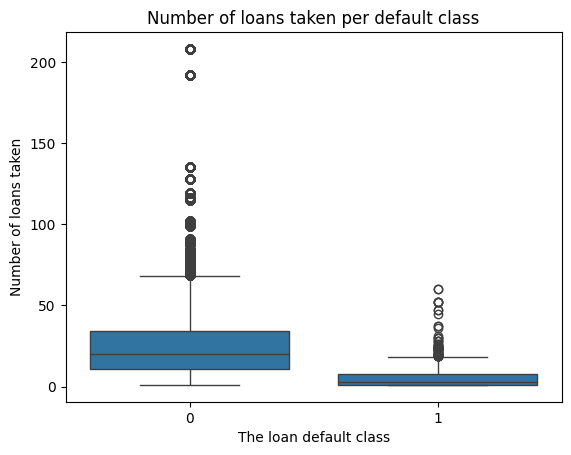

In [15]:
# How does my new feature look between the target classes?
sns.boxplot(x='target',y='loans_taken',data=train)
plt.xlabel('The loan default class')
plt.ylabel('Number of loans taken')
plt.title('Number of loans taken per default class')
plt.show()

In [16]:
# Investigate the categoricals
train['due_month_categorical'] = train['due_month'].astype('object')
train['disbursed_month_categorical'] = train['disbursement_month'].astype('object')
train['target'] = train['target'].astype('object')
train['lender_id'] = train['lender_id'].astype('object')
train['customer_id'] = train['customer_id'].astype('object')
train['tbl_loan_id'] = train['tbl_loan_id'].astype('object')

# Just checking the value counts for my categoricals
exclusions = ['ID', 'disbursement_date','due_date','customer_id','tbl_loan_id'] # Too many to visually see
categoricals = train.select_dtypes(include='object')
for c in categoricals.columns:
  if c not in exclusions:
    print(f'{c}: {categoricals[c].value_counts()}')

country_id: country_id
Kenya    68654
Name: count, dtype: int64
lender_id: lender_id
267278    64653
251804     3542
267277      271
245684      188
Name: count, dtype: int64
loan_type: loan_type
Type_1     61723
Type_7      2790
Type_5      1521
Type_4      1235
Type_10      466
Type_6       357
Type_9       205
Type_14       99
Type_2        74
Type_11       42
Type_18       30
Type_17       23
Type_12       21
Type_23       18
Type_20       13
Type_16       12
Type_13       10
Type_19        4
Type_15        4
Type_21        3
Type_24        3
Type_22        1
Name: count, dtype: int64
New_versus_Repeat: New_versus_Repeat
Repeat Loan    68087
New Loan         567
Name: count, dtype: int64
target: target
0    67396
1     1258
Name: count, dtype: int64
due_month_categorical: due_month_categorical
9     15504
8     15393
10    14659
11    10890
7      8196
12     2211
2       373
3       363
4       317
1       288
6       248
5       212
Name: count, dtype: int64
disbursed_month_categ

Imbalanced target variable, this would need addressing.

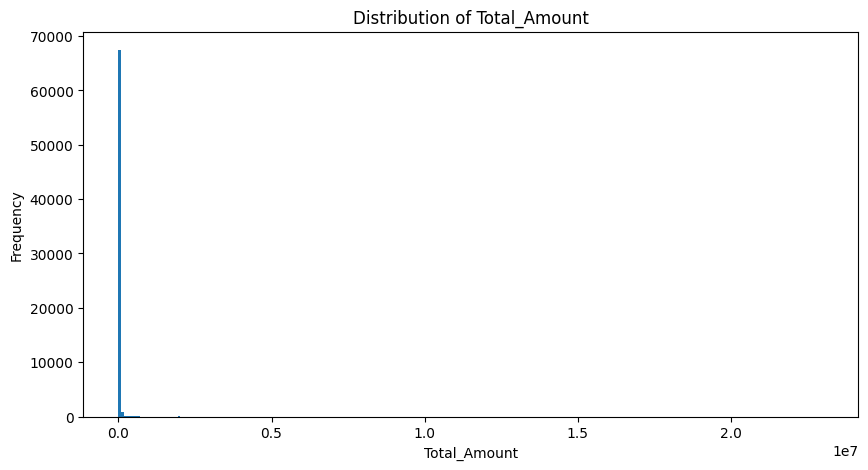

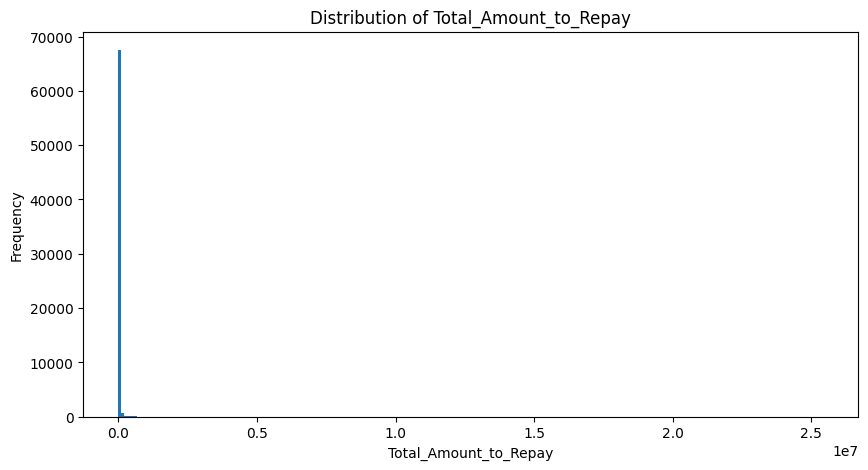

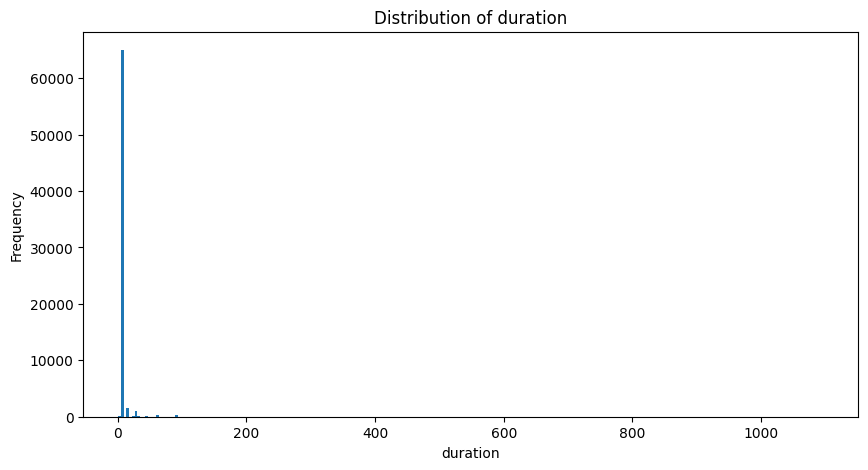

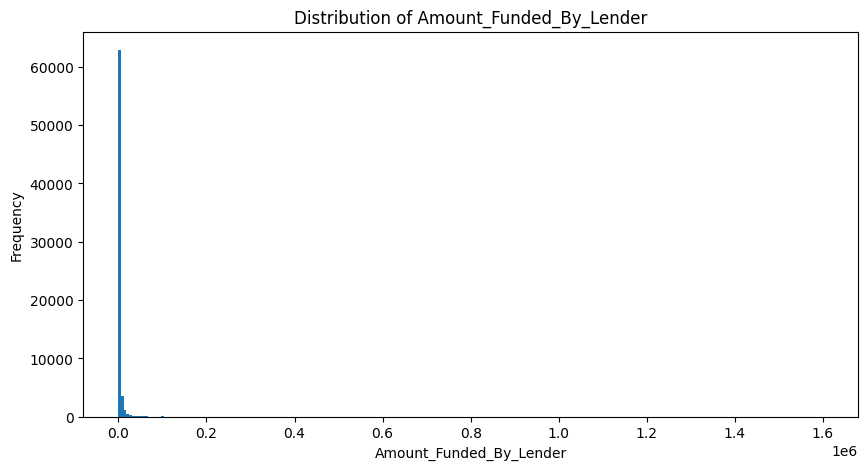

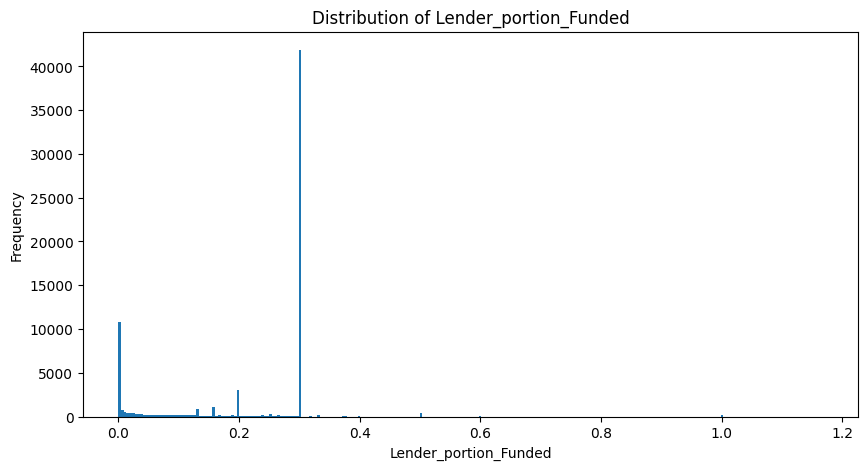

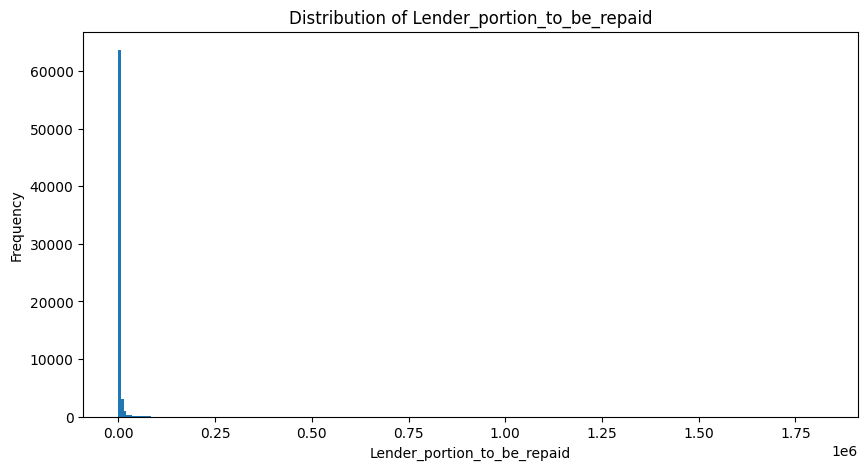

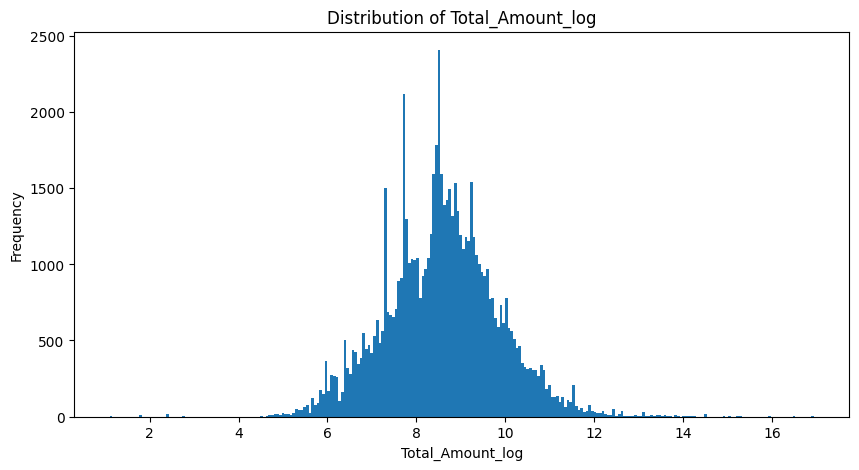

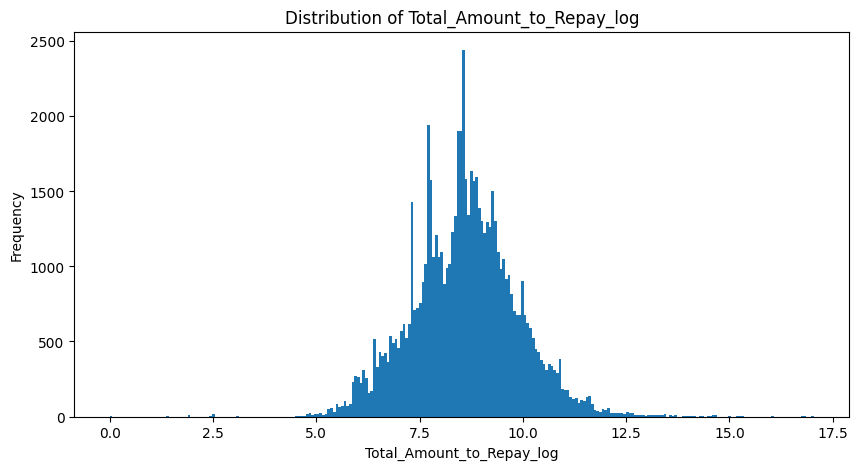

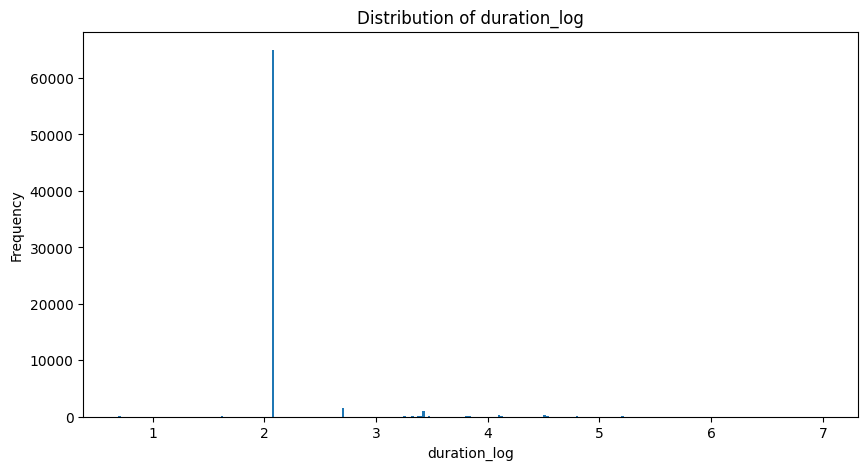

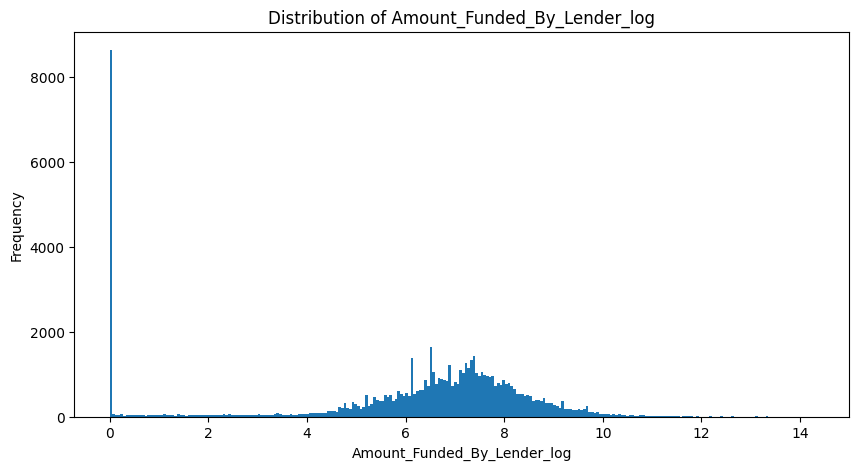

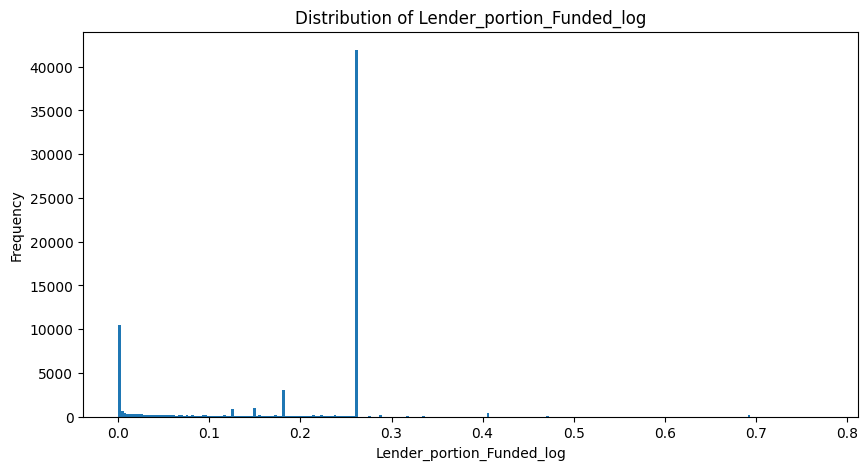

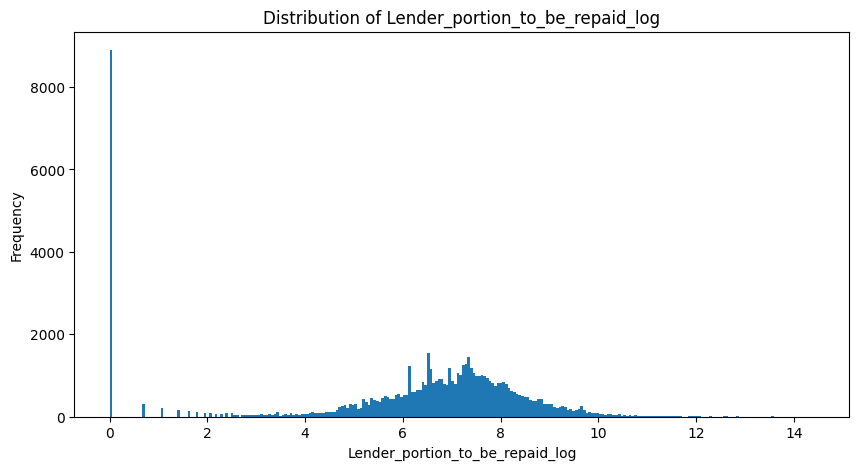

In [20]:
# Subsetting for just the log transformed features
numericals = train[['Total_Amount','Total_Amount_to_Repay','duration','Amount_Funded_By_Lender','Lender_portion_Funded','Lender_portion_to_be_repaid','Total_Amount_log','Total_Amount_to_Repay_log','duration_log','Amount_Funded_By_Lender_log','Lender_portion_Funded_log','Lender_portion_to_be_repaid_log']]
for n in numericals.columns:
  bin = int(np.sqrt(len(train)))  # Setting the number of bins as the square root of the length

  plt.figure(figsize=(10,5))
  plt.hist(train[n], bins=bin)
  plt.title(f'Distribution of {n}')
  plt.xlabel(n)
  plt.ylabel('Frequency')
  plt.show()

Log transformed my values due to skewing. Very difficult to see the trends of the raw values.

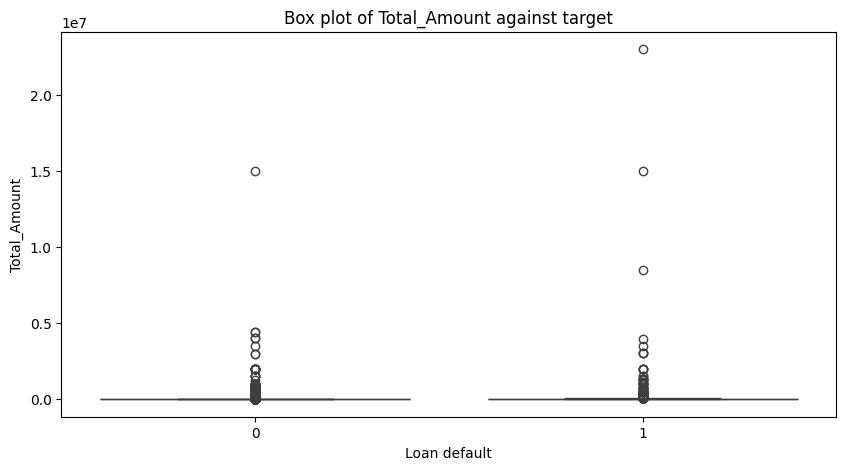

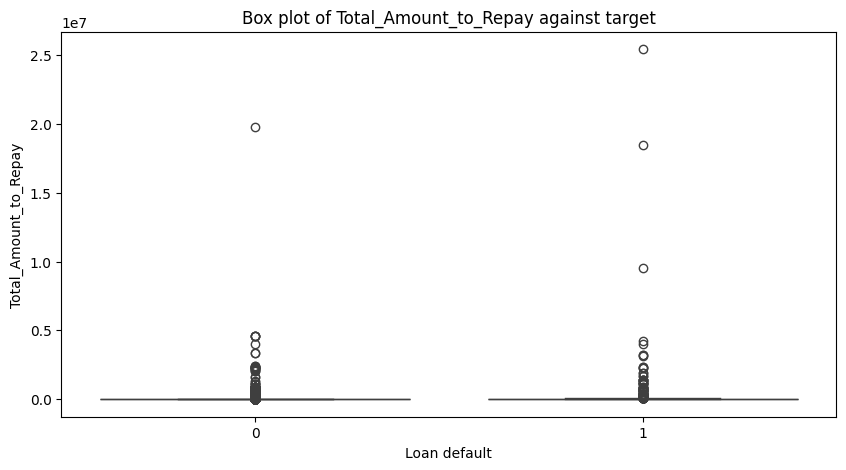

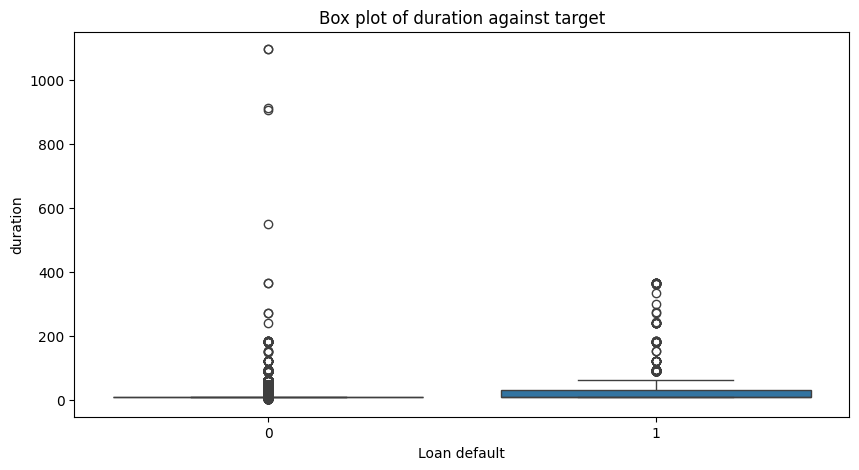

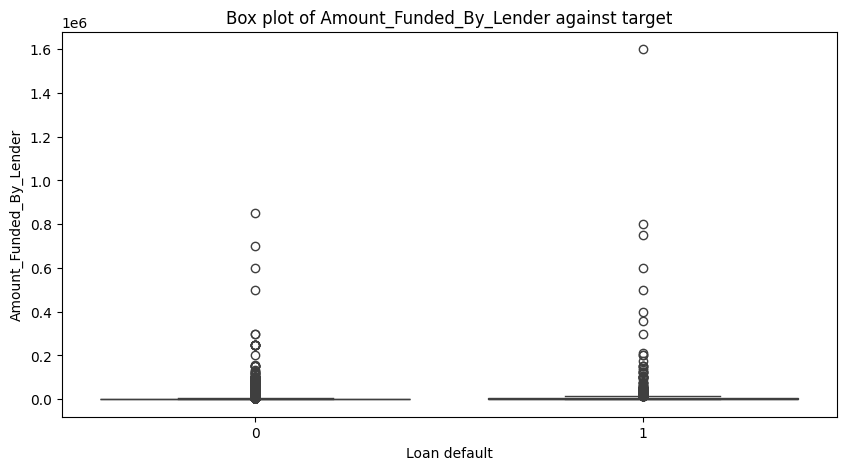

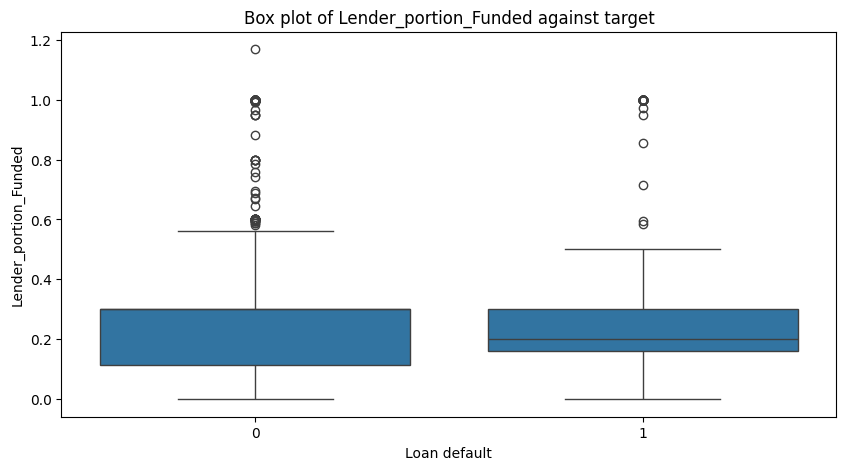

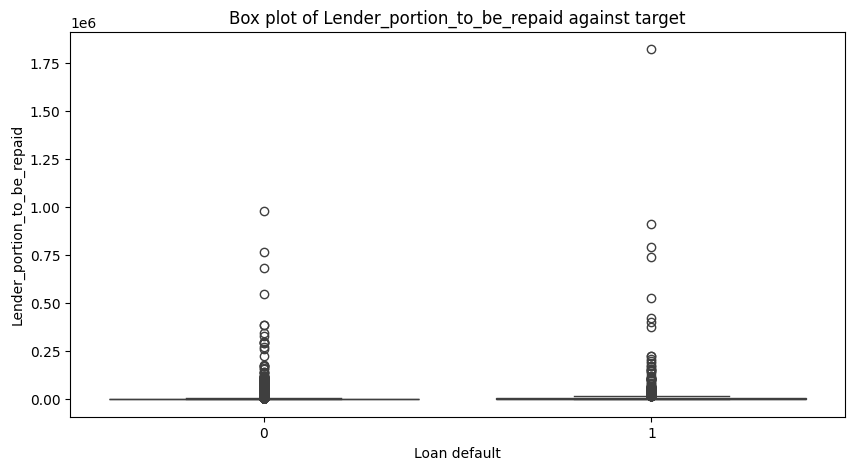

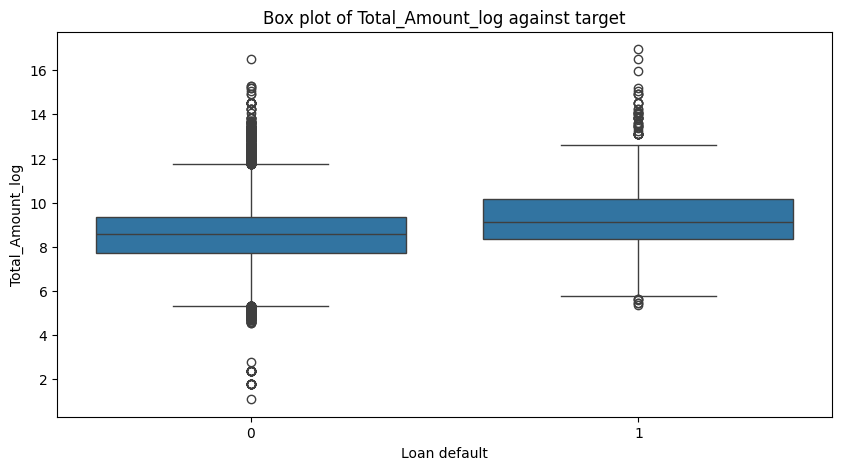

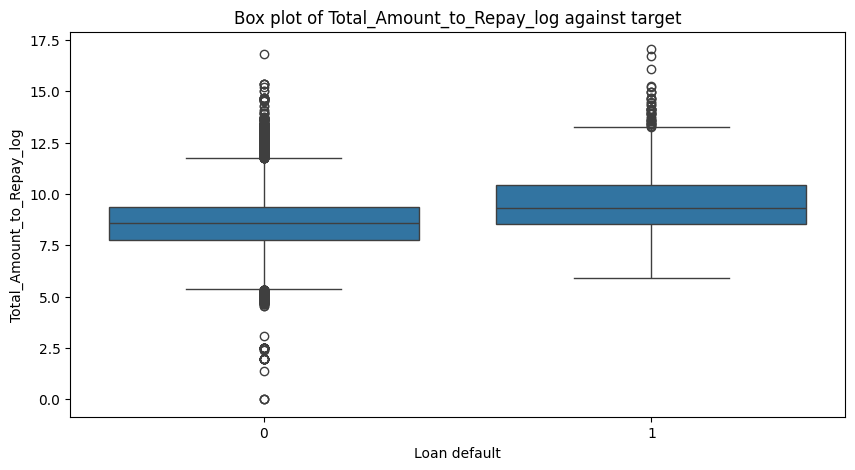

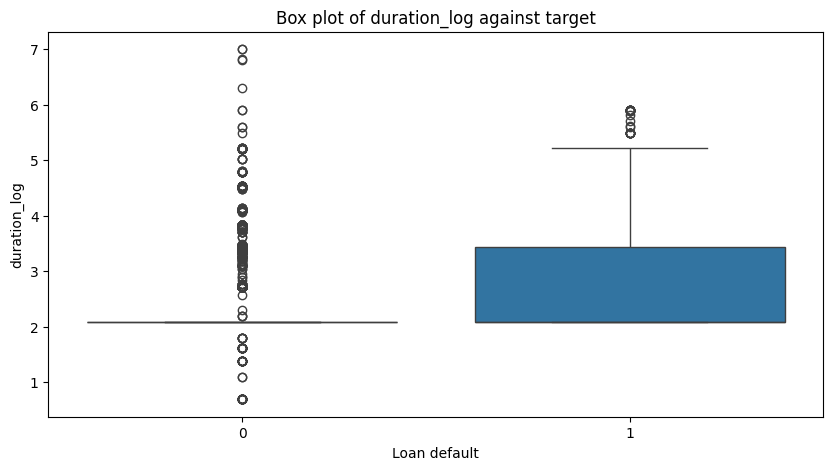

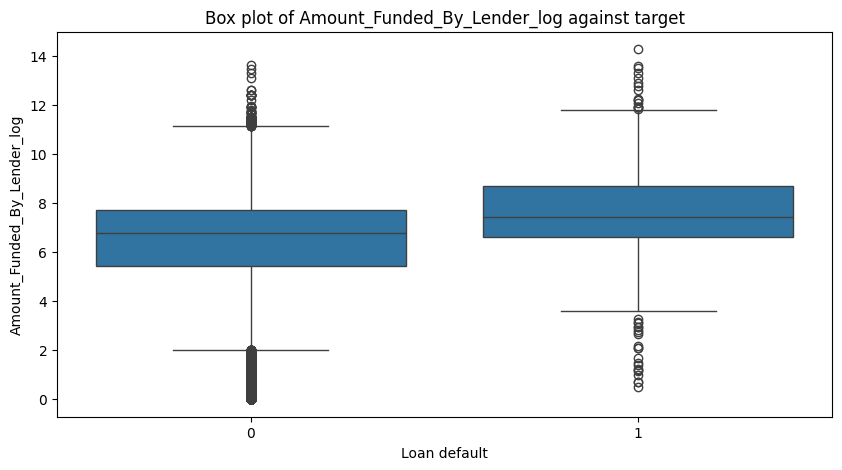

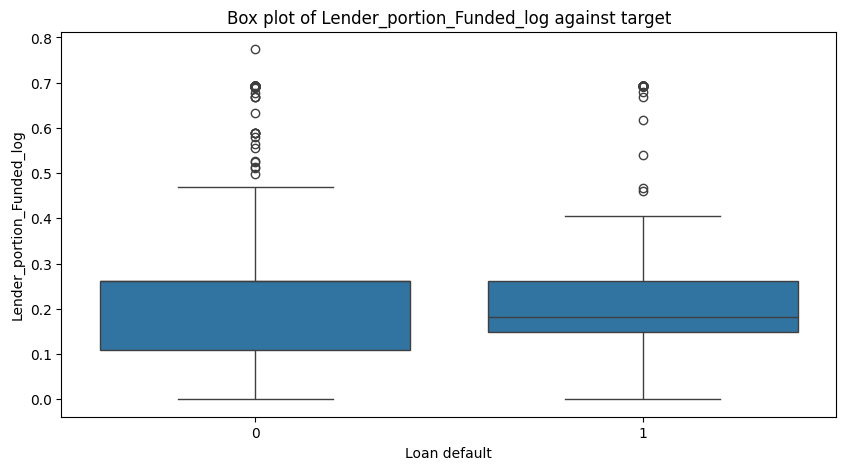

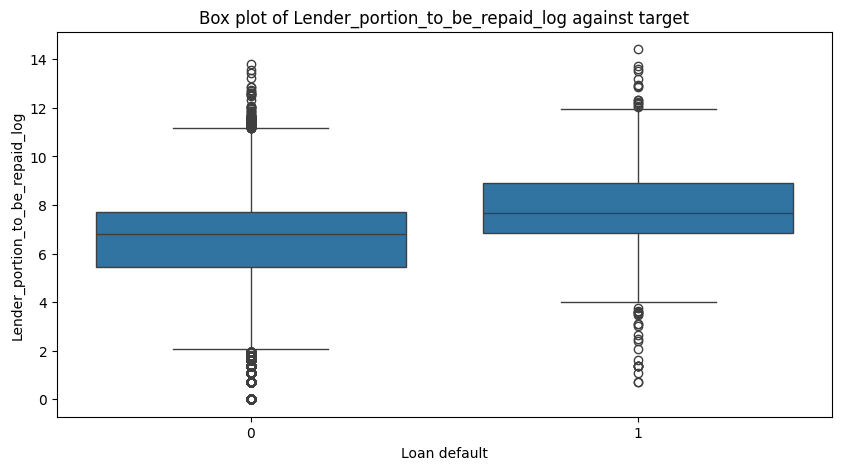

In [21]:
# Boxplots of target vs features, using numericals and exclusions from before
for n in numericals.columns:
  plt.figure(figsize=(10,5))
  sns.boxplot(x='target', y=n, data=train)
  plt.title(f'Box plot of {n} against target')
  plt.xlabel('Loan default')
  plt.ylabel(n)
  plt.show()


Again, due to the data spread, it's easier to spot trends in the log transformed data.

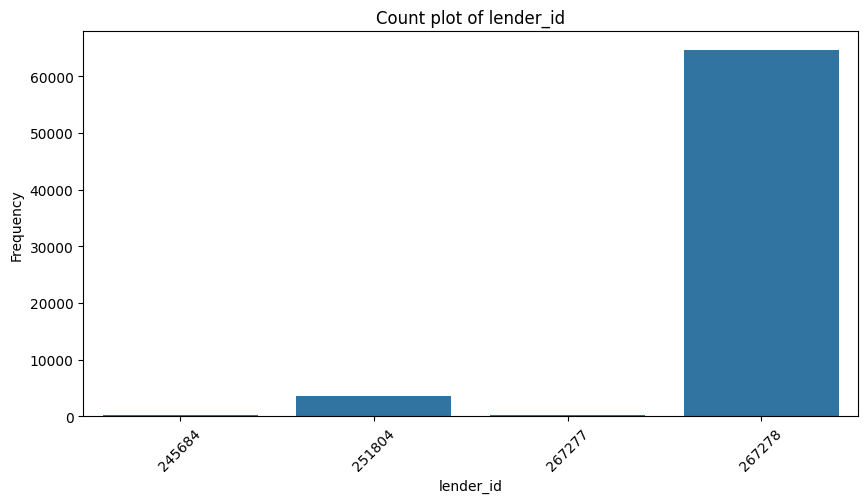

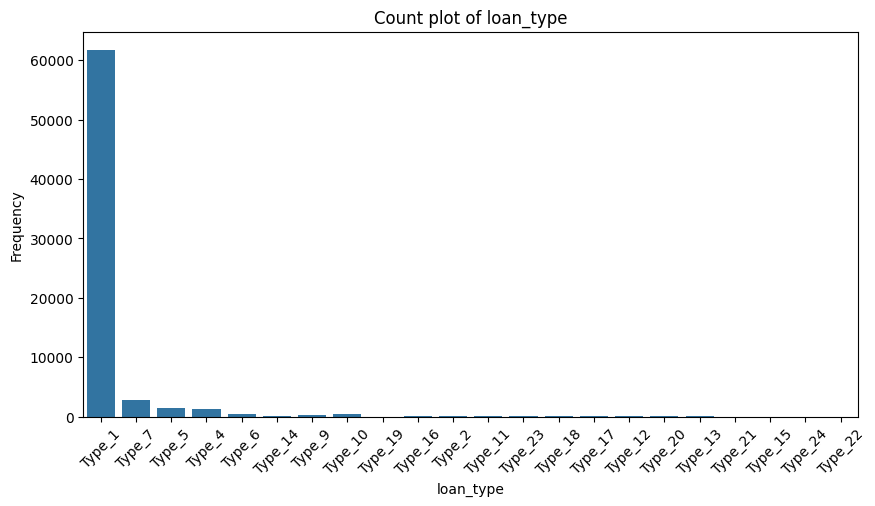

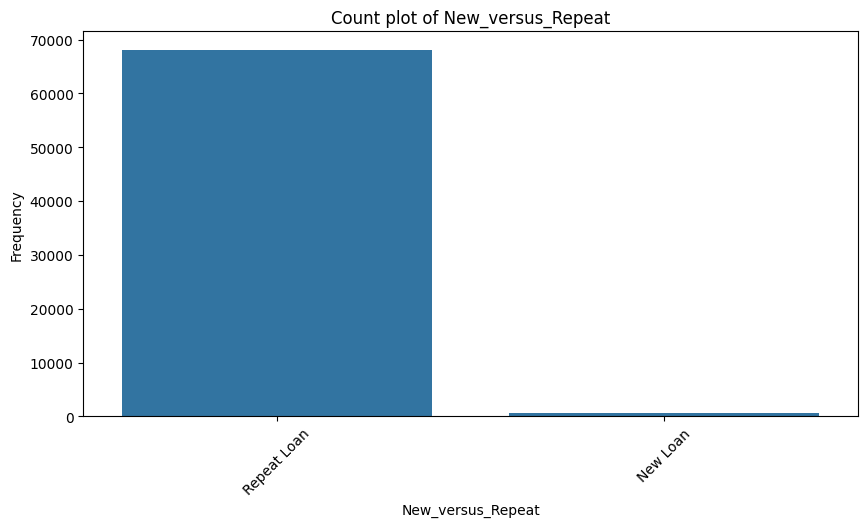

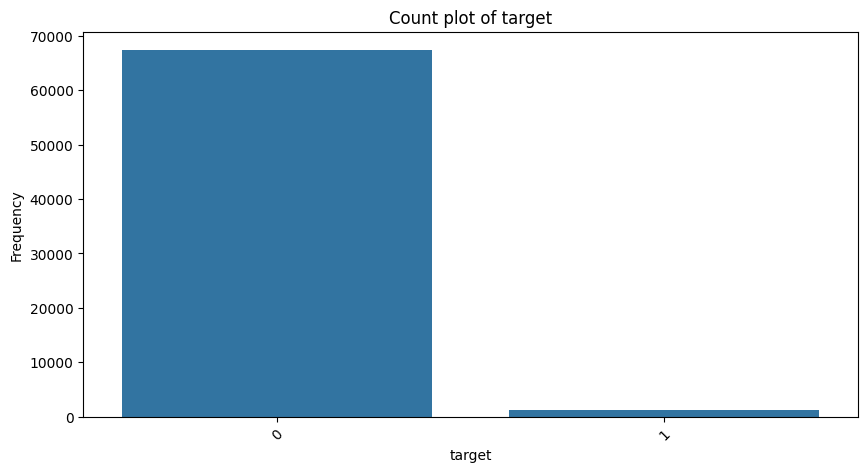

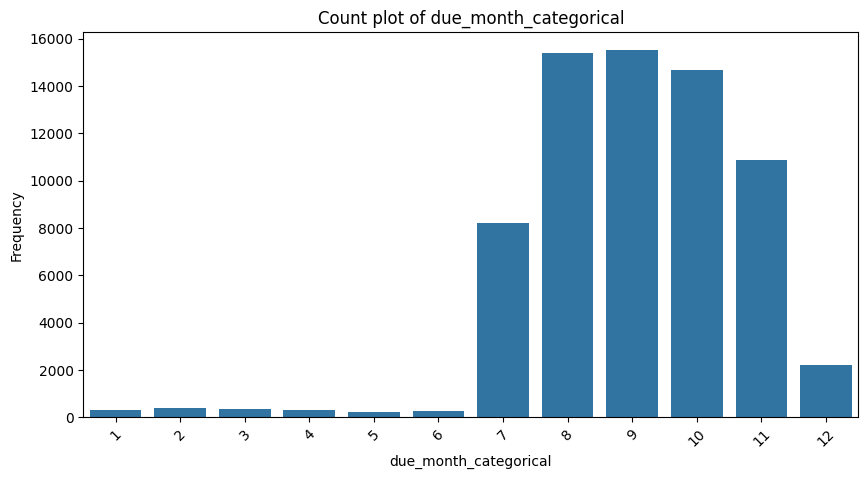

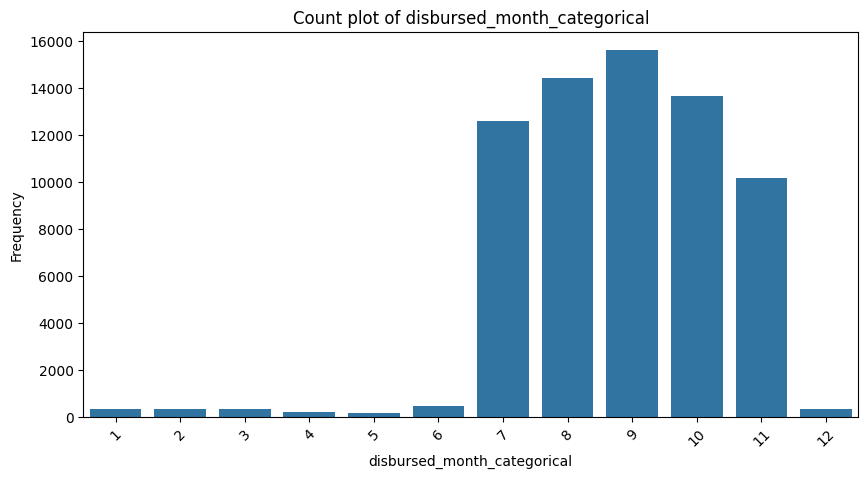

In [24]:
# Countplots for all my categorical features
exclude = ['ID','customer_id','tbl_loan_id','country_id']
for c in categoricals.columns:
  if c not in exclude:
    plt.figure(figsize=(10,5))
    sns.countplot(x=c, data=train)
    plt.title(f'Count plot of {c}')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

1. A very dominant lender id and loan_type in the dataset
2. Majority are repeat loans
3. Massive class imbalance in our target class, very few loan defaults in our dataset
4. Most of our loans are taken and paid in the second half of the year

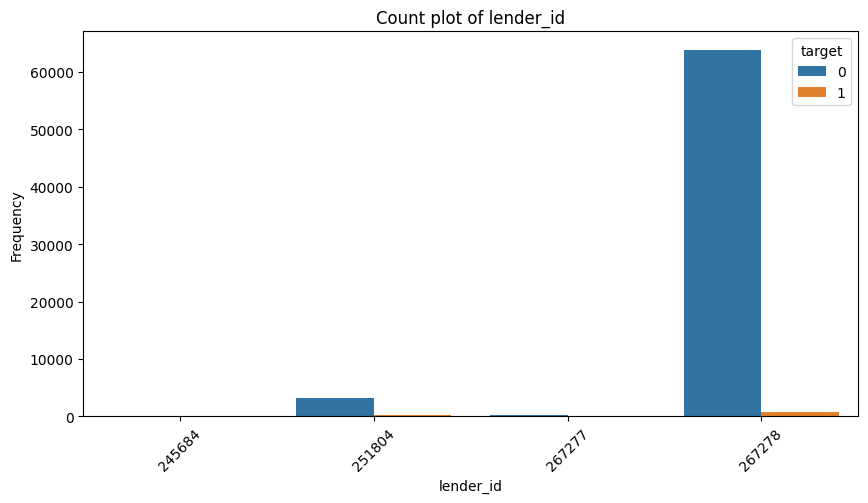

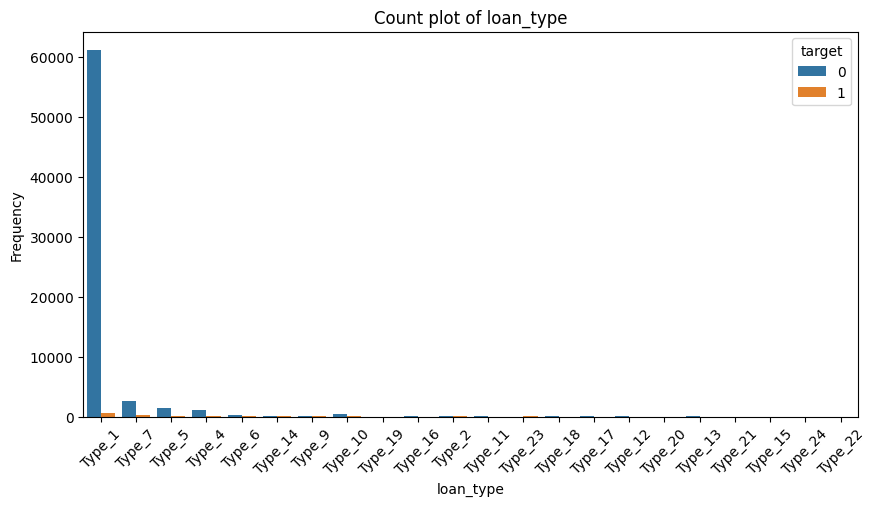

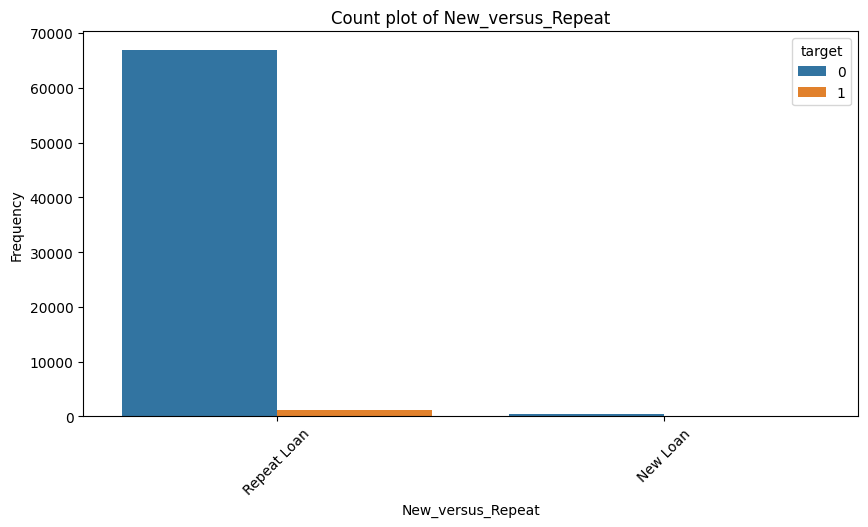

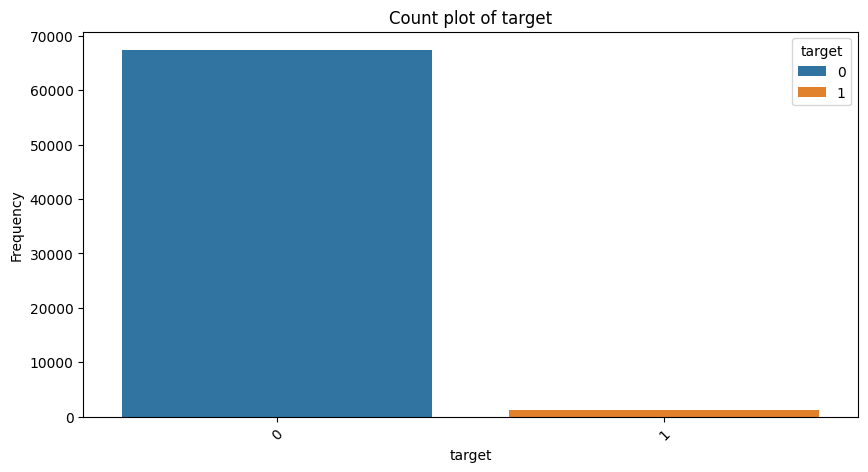

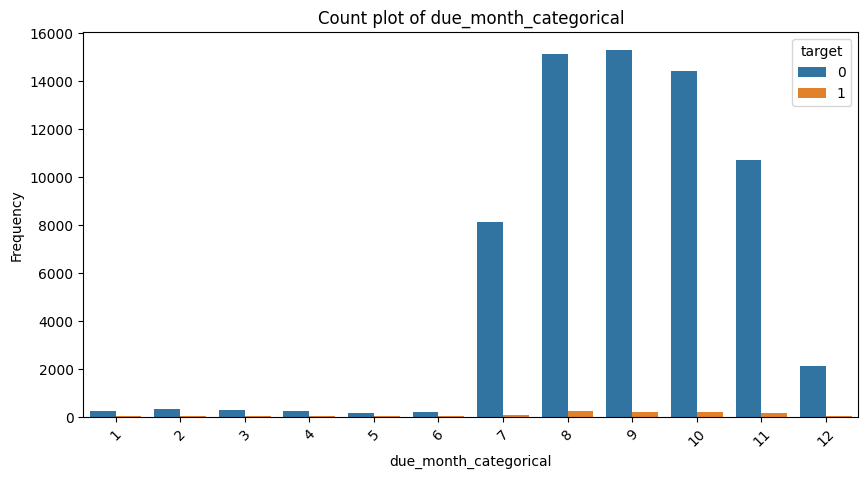

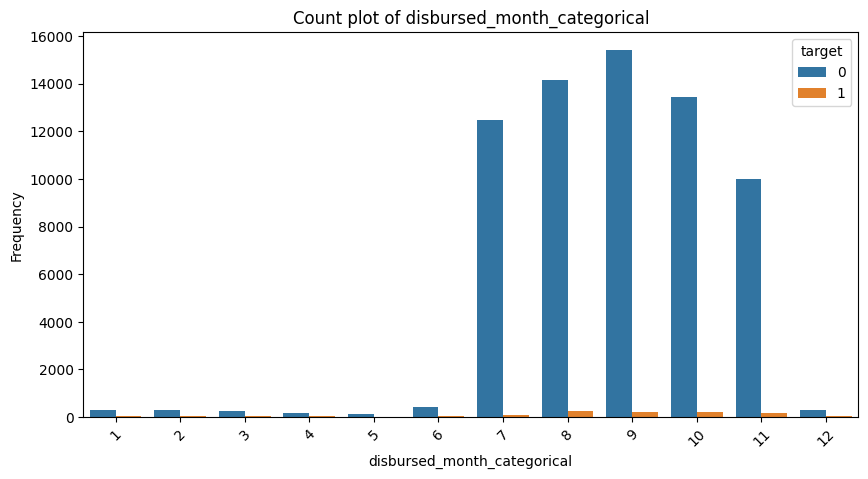

In [25]:
# Splitting our categorical features by our target variable
for c in categoricals.columns:
  if c not in exclude:
    plt.figure(figsize=(10,5))
    sns.countplot(x=c, data=train, hue='target')
    plt.title(f'Count plot of {c}')
    plt.xlabel(c)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Feature Engineering

The below feature had the biggest impact.

In [ ]:
# Creating a ratio of how much is left of the debt
train['repayment_ratio'] = train['Total_Amount_to_Repay'] / train['Total_Amount']
test['repayment_ratio'] = test['Total_Amount_to_Repay'] / test['Total_Amount']

In [29]:
# Binning our duration column to reduce some noise
bins = [0,30,180,365, float('inf')]
labels = ['Short-term','Medium-term','Long-term','Very-long term']

train['Duration category'] = pd.cut(train['duration'], bins=bins, labels=labels)
test['Duration category'] = pd.cut(test['duration'], bins=bins, labels=labels)


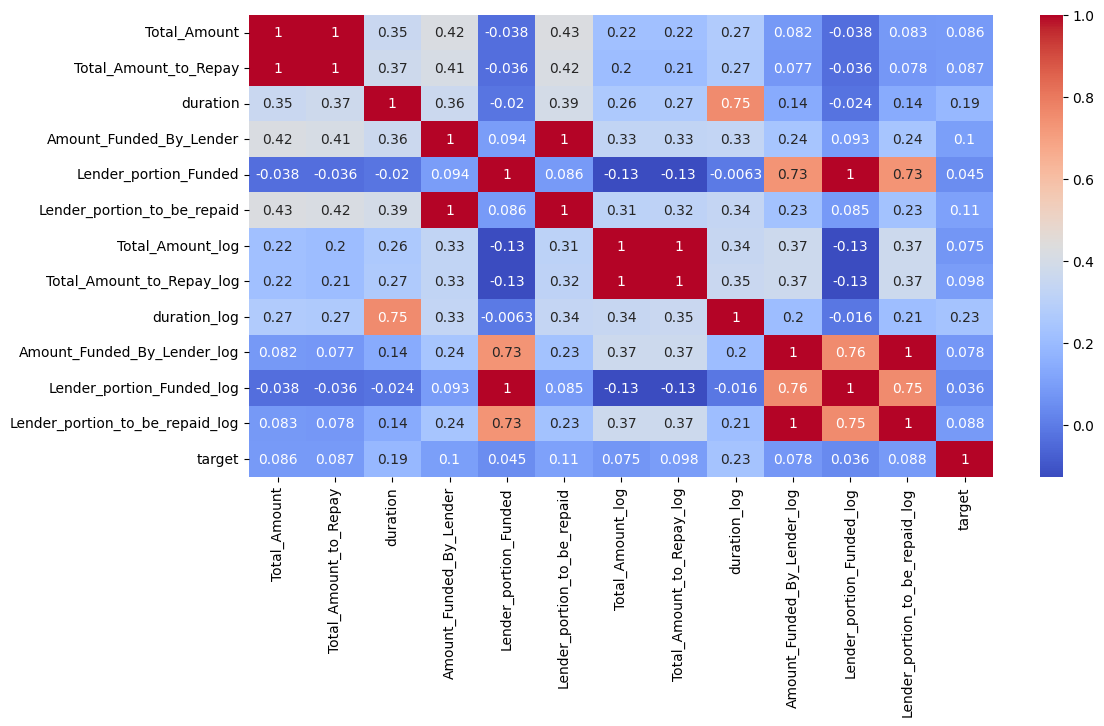

In [31]:
# Correlation matrix
# nums = exclusive_df.select_dtypes(exclude='object')
plt.figure(figsize=(12,6))
corr_matrix = numericals.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Our features are highly correlated as a number of columns are showing the same thing, thus will either use log transformed or raw data and not both.

In [32]:
# Do we have multiple tbl_loan_ids?
threshold = 1
focus = train['tbl_loan_id'].value_counts()
need = focus[focus > threshold]

# Duplicates
duplicated = train[train['tbl_loan_id'].isin(need.index)]
duplicated

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,Total_Amount_log,Total_Amount_to_Repay_log,duration_log,Amount_Funded_By_Lender_log,Lender_portion_Funded_log,Lender_portion_to_be_repaid_log,disbursement_year,disbursement_month,disbursement_day,due_year,due_month,due_day,repayment_ratio,loans_taken,due_month_categorical,disbursed_month_categorical,Duration category
25,ID_308408369553251804,308408,Kenya,369553,251804,Type_7,28000.00,29166.00,2024-08-24,2024-08-31,7,Repeat Loan,5600.00,0.20,5833.00,0,10.24,10.28,2.08,8.63,0.18,8.67,2024,8,24,2024,8,31,1.04,17,8,8,Short-term
36,ID_238716357554267278,238716,Kenya,357554,267278,Type_4,30000.00,33600.00,2023-08-07,2023-10-06,60,Repeat Loan,1400.00,0.05,1568.00,0,10.31,10.42,4.11,7.24,0.05,7.36,2023,8,7,2023,10,6,1.12,14,10,8,Medium-term
53,ID_246549270168251804,246549,Kenya,270168,251804,Type_5,55000.00,57850.00,2022-09-29,2022-10-13,14,Repeat Loan,8800.00,0.16,9256.00,0,10.92,10.97,2.71,9.08,0.15,9.13,2022,9,29,2022,10,13,1.05,16,10,9,Short-term
65,ID_308549368425267278,308549,Kenya,368425,267278,Type_7,6554.00,6784.00,2024-08-02,2024-08-09,7,Repeat Loan,1311.00,0.20,1357.00,0,8.79,8.82,2.08,7.18,0.18,7.21,2024,8,2,2024,8,9,1.04,13,8,8,Short-term
79,ID_308938372922267278,308938,Kenya,372922,267278,Type_7,1710.00,1770.00,2024-10-10,2024-10-17,7,Repeat Loan,342.00,0.20,354.00,0,7.44,7.48,2.08,5.84,0.18,5.87,2024,10,10,2024,10,17,1.04,10,10,10,Short-term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68570,ID_248038368423267278,248038,Kenya,368423,267278,Type_7,32307.00,33438.00,2024-08-01,2024-08-08,7,Repeat Loan,6461.00,0.20,6687.00,0,10.38,10.42,2.08,8.77,0.18,8.81,2024,8,1,2024,8,8,1.04,14,8,8,Short-term
68572,ID_199820370933267278,199820,Kenya,370933,267278,Type_7,5000.00,5176.00,2024-09-12,2024-09-19,7,Repeat Loan,1000.00,0.20,1035.00,0,8.52,8.55,2.08,6.91,0.18,6.94,2024,9,12,2024,9,19,1.04,17,9,9,Short-term
68597,ID_310153373087251804,310153,Kenya,373087,251804,Type_7,6000.00,6211.00,2024-10-12,2024-10-19,7,Repeat Loan,1200.00,0.20,1242.00,0,8.70,8.73,2.08,7.09,0.18,7.13,2024,10,12,2024,10,19,1.04,5,10,10,Short-term
68611,ID_252778295775251804,252778,Kenya,295775,251804,Type_5,10280.00,10894.00,2022-11-08,2022-11-22,14,Repeat Loan,1644.00,0.16,1742.00,0,9.24,9.30,2.71,7.41,0.15,7.46,2022,11,8,2022,11,22,1.06,10,11,11,Short-term


In [33]:
# Customer ID?
# Do we have the same customer ID appearing multiple times
threshold = 1
focus = train['customer_id'].value_counts()
need = focus[focus > threshold]

# How is the target class split for duplicate customer_ids
duplicated_id = train[train['customer_id'].isin(need.index)]
duplicated_id = duplicated_id.sort_values(by='customer_id', ascending=False)
duplicated_id['target'].value_counts()

target
0    66514
1      928
Name: count, dtype: int64

In [34]:
# This function shows how many lenders are in a loan
def unique_id(df): 
    check = pd.DataFrame(df['tbl_loan_id'].value_counts()).reset_index()
    df = df.merge(check, on='tbl_loan_id',how='left')
    df = df.rename(columns={'count':'Lender_numbers'})
    return df

train = unique_id(train)
test = unique_id(test)


In [40]:
print(f"Training lenders:{train['Lender_numbers'].value_counts()}")
print(f"Test set lenders:{test['Lender_numbers'].value_counts()}")

Training lenders:Lender_numbers
1    64386
2     4268
Name: count, dtype: int64
Test set lenders:Lender_numbers
1    15576
2     2910
3      108
Name: count, dtype: int64


In [41]:
# What's the spread of years for disbursement and due dates
def date_processing(df):
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])
    df['due_date'] = pd.to_datetime(df['due_date'])
    
    # Get month, day and year
    df['disbursement_year'] = df['disbursement_date'].dt.year
    df['disbursement_month'] = df['disbursement_date'].dt.month
    df['disbursement_day'] = df['disbursement_date'].dt.day
    
    df['due_year'] = df['due_date'].dt.year
    df['due_month'] = df['due_date'].dt.month
    df['due_day'] = df['due_date'].dt.day
    return df

train = date_processing(train)
test = date_processing(test)



In [43]:
# Changing the lender_id dtypes
train['lender_id'] = train['lender_id'].astype(object)
test['lender_id'] = test['lender_id'].astype(object)

Below is the economics indicators data, providing further info on the countries. Including them improved my score locally but not on the leaderboard. I therefore didn't include them in my features but have just shown them below.

In [66]:
# Economic indicators
indicators_df = pd.read_csv('C:\\Users\\josha\\Downloads\\african-credit-scoring-challenge20241203-14702-1yayxml\economic_indicators.csv')
indicators_df.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,YR2009,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.51,9.36,29.77,18.04,15.44,11.68,10.73,16.49,19.25,10.73,8.73,11.19,11.67,15.49,17.15,17.45,12.37,7.81,7.14,9.89,9.97,31.26,38.11
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.36,3.08,3.30,1.46,3.89,2.47,1.89,6.31,1.02,1.23,4.91,1.30,2.58,0.45,1.25,0.72,0.69,0.36,-1.11,2.43,4.09,5.28,4.39
2,Kenya,"Inflation, consumer prices (annual %)",5.74,1.96,9.82,11.62,10.31,14.45,9.76,26.24,9.23,3.96,14.02,9.38,5.72,6.88,6.58,6.30,8.01,4.69,5.24,5.41,6.11,7.66,7.67
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.72,0.79,0.87,0.90,0.91,0.92,0.93,1.05,1.40,1.43,1.52,1.82,1.98,2.90,3.71,3.91,4.35,4.59,5.22,5.60,5.81,8.27,11.02
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.40,693.71,579.90,527.34,527.26,522.43,478.63,446.00,470.29,494.79,471.25,510.56,493.90,493.76,591.21,592.61,580.66,555.45,585.91,575.59,554.53,623.76,606.57


In [67]:
# Melt the DataFrame to make years rows instead of columns
melted = pd.melt(indicators_df, id_vars=["Country", "Indicator"], var_name="Year", value_name="Value")

# Pivot to make each indicator its own column
economics_df = melted.pivot_table(index=["Country", "Year"], columns="Indicator", values="Value").reset_index()

# Keep the year numericals
economics_df['Year'] = economics_df['Year'].str[2:].astype(int)
economics_df.head()


Indicator,Country,Year,Average precipitation in depth (mm per year),Deposit interest rate (%),Fossil fuel energy consumption (% of total),"Inflation, consumer prices (annual %)","Interest rate spread (lending rate minus deposit rate, %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Real interest rate (%),Unemployment rate
0,Cote d'Ivoire,2001,1348.00,NaN,34.30,4.36,NaN,NaN,732.40,NaN,5.20
1,Cote d'Ivoire,2002,1348.00,NaN,37.85,3.08,NaN,NaN,693.71,NaN,5.52
2,Cote d'Ivoire,2003,1348.00,NaN,32.50,3.30,NaN,NaN,579.90,NaN,5.86
3,Cote d'Ivoire,2004,1348.00,NaN,24.93,1.46,NaN,NaN,527.34,NaN,5.93
4,Cote d'Ivoire,2005,1348.00,7.61,25.39,3.89,-0.56,7.05,527.26,5.76,6.04


In [47]:
# A fair amomunt of null values, in addition there's no 2024 data
economics_df.isnull().sum()

Indicator
Country                                                       0
Year                                                          0
Average precipitation in depth (mm per year)                  6
Deposit interest rate (%)                                    10
Fossil fuel energy consumption (% of total)                  27
Inflation, consumer prices (annual %)                         0
Interest rate spread (lending rate minus deposit rate, %)    33
Lending interest rate (%)                                    33
Official exchange rate (LCU per US$, period average)          0
Real interest rate (%)                                       33
Unemployment rate                                             0
dtype: int64

I commented out the merging as I didn't include the features but the code shows my approach. 

In [ ]:
# # Some merging
# train = train.merge(economics_df, left_on=['country_id','disbursement_year'], right_on=['Country','Year'],how='left')
# test = test.merge(economics_df, left_on=['country_id','disbursement_year'], right_on=['Country','Year'],how='left')


In [ ]:
# # Drop these cols
# train = train.drop(columns=['Average precipitation in depth (mm per year)','Fossil fuel energy consumption (% of total)'])
# test = test.drop(columns=['Average precipitation in depth (mm per year)','Fossil fuel energy consumption (% of total)'])
# # test = test.fillna(0)

In [49]:
# Created this function to get the actual day of the week from train and test set
def get_day_name(df):
    # Disbursement Date and due date
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'], format="%Y-%m-%d")
    df['due_date'] = pd.to_datetime(df['due_date'], format="%Y-%m-%d")
    
    # Extract day names
    df['Disbursement Day'] = df['disbursement_date'].dt.strftime("%A")
    df['Due Day'] = df['due_date'].dt.strftime("%A")
    return df

In [50]:
train = get_day_name(train)
test = get_day_name(test)

In [52]:
# Similar spread across
print(test['Disbursement Day'].value_counts())
print(test['Due Day'].value_counts())

Disbursement Day
Saturday     3377
Monday       3274
Wednesday    3070
Thursday     2899
Friday       2717
Tuesday      2696
Sunday        561
Name: count, dtype: int64
Due Day
Saturday     3490
Monday       3249
Wednesday    3053
Thursday     2754
Tuesday      2683
Friday       2657
Sunday        708
Name: count, dtype: int64


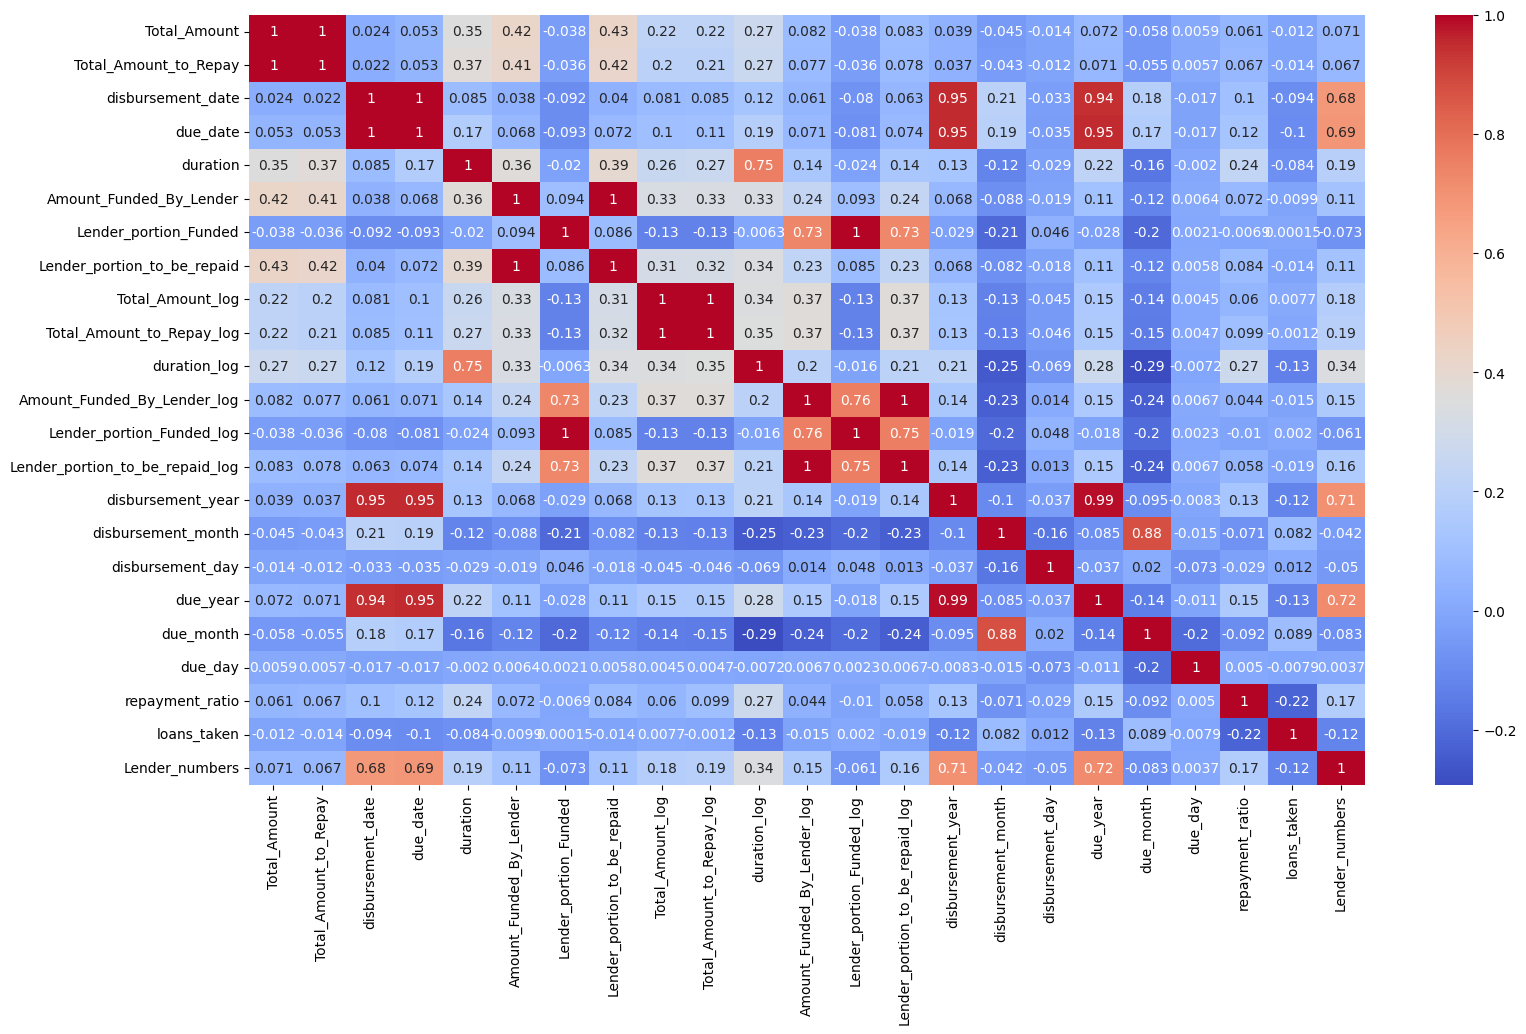

In [57]:
# Corr matrix
nums = train.select_dtypes(exclude=['object','category'])


plt.figure(figsize=(18,10))
corr_matrix = nums.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Quite a bit of multicolinearity

In [76]:
# This feature simply shows the ratio of new to returning customers each lender has.
def new_vs_returning(df):
    # Lenders and returning customers?
    grouped_ratio = df.groupby(['lender_id','New_versus_Repeat']).agg(counts=('New_versus_Repeat','count'))
    
    # Creating a new to repeat ratio
    loan_counts = grouped_ratio.unstack(fill_value=0)['counts']
    loan_counts['new vs repeat ratio'] = loan_counts['New Loan'] / loan_counts['Repeat Loan']
    
    # Reset the index of loan_counts
    loan_counts = loan_counts.reset_index()
    df = df.merge(loan_counts[['lender_id','new vs repeat ratio']], on='lender_id')
    return df

train = new_vs_returning(train)
test = new_vs_returning(test)

In [77]:
# Experimenting with some interaction features
def final_features(df):
    df['lender_funded_ratio'] = df['Lender_portion_Funded'] / df['Total_Amount']
    df['lender_repay_ratio'] = df['Lender_portion_to_be_repaid'] / df['Total_Amount_to_Repay']
    return df

# Applying it
train = final_features(train)
test = final_features(test)

In [78]:
# Replaced infinite values with 0 for cases where denominator was 0
train['lender_repay_ratio'] = train['lender_repay_ratio'].replace(np.inf,0)
test['lender_repay_ratio'] = test['lender_repay_ratio'].replace(np.inf,0)

count   68654.00
mean        0.22
std         0.13
min         0.00
25%         0.12
50%         0.30
75%         0.30
max         1.71
Name: lender_repay_ratio, dtype: float64

In [79]:
# Setting weekdays or weekends
def weekday_or_weekend(df):
    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday']

    # Set as weekday or weekend for some more filtering
    df['weekday/weekend'] = np.where(df['Due Day'].isin(weekdays),'Weekday','Weekend')
    return df

train = weekday_or_weekend(train)
test = weekday_or_weekend(test)

# Outlier investigation

In [69]:
# Computing z scores for numericals

nums = train[['Total_Amount','Total_Amount_to_Repay','Amount_Funded_By_Lender','Lender_portion_Funded','Lender_portion_to_be_repaid']]
for col in nums.columns:
    nums[f'{col}_zscore'] = zscore(nums[col])

nums

,Total_Amount,Total_Amount_to_Repay,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,Total_Amount_zscore,Total_Amount_to_Repay_zscore,Amount_Funded_By_Lender_zscore,Lender_portion_Funded_zscore,Lender_portion_to_be_repaid_zscore
0,8448.00,8448.00,120.85,0.01,121.00,-0.05,-0.04,-0.20,-1.57,-0.19
1,25895.00,25979.00,7768.50,0.30,7794.00,0.08,0.06,0.44,0.63,0.38
2,6900.00,7142.00,1380.00,0.20,1428.00,-0.06,-0.05,-0.10,-0.14,-0.09
3,8958.00,9233.00,2687.40,0.30,2770.00,-0.04,-0.04,0.01,0.63,0.01
4,4564.00,4728.00,1369.20,0.30,1418.00,-0.07,-0.07,-0.10,0.63,-0.09
...,...,...,...,...,...,...,...,...,...,...
68649,1460.00,1515.00,438.00,0.30,455.00,-0.09,-0.09,-0.18,0.63,-0.16
68650,5029.00,5116.00,1508.70,0.30,1535.00,-0.07,-0.06,-0.09,0.63,-0.08
68651,5289.00,5289.00,1586.70,0.30,1587.00,-0.07,-0.06,-0.08,0.63,-0.08
68652,3334.00,3334.00,741.09,0.22,741.00,-0.08,-0.07,-0.15,0.03,-0.14


In [70]:
# Filtering the zscore columns
zscore_cols = [col for col in nums.columns if '_zscore' in col]

# Any value wth a zscore of >3 is considered an outlier in this case
outlier_rows = nums[(nums[zscore_cols]>3).any(axis=1)]
outlier_rows

,Total_Amount,Total_Amount_to_Repay,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,Total_Amount_zscore,Total_Amount_to_Repay_zscore,Amount_Funded_By_Lender_zscore,Lender_portion_Funded_zscore,Lender_portion_to_be_repaid_zscore
105,10000.00,11111.00,10000.00,1.00,11111.00,-0.03,-0.03,0.63,6.02,0.63
369,10000.00,11111.00,10000.00,1.00,11111.00,-0.03,-0.03,0.63,6.02,0.63
455,150000.00,172500.00,37500.00,0.25,43125.00,0.95,0.95,2.93,0.24,3.02
503,1542000.00,2374900.00,250000.00,0.16,385040.00,10.78,14.29,20.75,-0.44,28.58
550,700000.00,794500.00,93333.00,0.13,105933.00,4.84,4.72,7.61,-0.66,7.72
...,...,...,...,...,...,...,...,...,...,...
68440,210000.00,231105.00,45019.19,0.21,49544.00,1.38,1.31,3.56,-0.03,3.50
68449,1000000.00,1135000.00,50000.00,0.05,56750.00,6.95,6.78,3.98,-1.30,4.04
68471,128180.00,128180.00,38454.00,0.30,38454.00,0.80,0.68,3.01,0.63,2.68
68521,12000.00,12840.00,12000.00,1.00,12840.00,-0.02,-0.02,0.79,6.02,0.76


In [72]:
# Mapping it back to the original dataframe
outliers_df = train.loc[outlier_rows.index]
outliers_df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,Total_Amount_log,Total_Amount_to_Repay_log,duration_log,Amount_Funded_By_Lender_log,Lender_portion_Funded_log,Lender_portion_to_be_repaid_log,disbursement_year,disbursement_month,disbursement_day,due_year,due_month,due_day,repayment_ratio,loans_taken,due_month_categorical,disbursed_month_categorical,Duration category,Lender_numbers,Disbursement Day,Due Day,loan_type_grouped
105,ID_257748129373245684,257748,Kenya,129373,245684,Type_14,10000.00,11111.00,2022-03-21,2022-04-20,30,New Loan,10000.00,1.00,11111.00,1,9.21,9.32,3.43,9.21,0.69,9.32,2022,3,21,2022,4,20,1.11,1,4,3,Short-term,1,Monday,Wednesday,Others
369,ID_17894124935245684,17894,Kenya,124935,245684,Type_14,10000.00,11111.00,2022-03-11,2022-04-10,30,Repeat Loan,10000.00,1.00,11111.00,1,9.21,9.32,3.43,9.21,0.69,9.32,2022,3,11,2022,4,10,1.11,5,4,3,Short-term,1,Friday,Sunday,Others
455,ID_273698360408251804,273698,Kenya,360408,251804,Type_4,150000.00,172500.00,2023-10-30,2024-01-28,90,Repeat Loan,37500.00,0.25,43125.00,0,11.92,12.06,4.51,10.53,0.22,10.67,2023,10,30,2024,1,28,1.15,2,1,10,Medium-term,2,Monday,Sunday,Others
503,ID_272658288728251804,272658,Kenya,288728,251804,Type_19,1542000.00,2374900.00,2022-10-27,2025-10-27,1096,Repeat Loan,250000.00,0.16,385040.00,0,14.25,14.68,7.00,12.43,0.15,12.86,2022,10,27,2025,10,27,1.54,2,10,10,Very-long term,2,Thursday,Monday,Others
550,ID_267236186485267278,267236,Kenya,186485,267278,Type_4,700000.00,794500.00,2022-06-09,2022-09-07,90,Repeat Loan,93333.00,0.13,105933.00,0,13.46,13.59,4.51,11.44,0.13,11.57,2022,6,9,2022,9,7,1.14,4,9,6,Medium-term,1,Thursday,Wednesday,Others


In [73]:
outliers_df.groupby(['lender_id','New_versus_Repeat','target']).agg(ratio = ('New_versus_Repeat','count'))

ratio
lender_id New_versus_Repeat target       
245684    New Loan          0          25
                            1          62
          Repeat Loan       0          65
                            1          14
251804    Repeat Loan       0          99
                            1          17
267277    New Loan          0           1
                            1           4
          Repeat Loan       0          29
                            1          23
267278    New Loan          0           2
                            1           1
          Repeat Loan       0         205
                            1          26

Lender ID 245684 had most of their loan defaults coming from new loans, which is different from all the rest.

In [75]:
# Among our outliers who defaulted, is there any trend?
defaults = outliers_df[outliers_df['target']==1]
defaults['lender_id'].value_counts()

lender_id
245684    76
267278    27
267277    27
251804    17
Name: count, dtype: int64

# Features

In future, a more robust feature selection method will be needed, as my approach was quite experimental and reactive based on feature importance and the impact features had on the leaderboard score and my local score.

In [80]:
common_features = [
    'lender_id',
    'loan_type',
    'New_versus_Repeat',
    'Amount_Funded_By_Lender',
    'Lender_portion_Funded',
    'Lender_portion_to_be_repaid',
    'disbursement_month',
    'disbursement_day',
    'due_year',
    'due_month',
    'due_day',
    'Disbursement Day',
    'Due Day',
    'Duration category',
    'repayment_ratio',
    'loans_taken',
    'Lender_numbers',
    'new vs repeat ratio',
    'weekday/weekend',
    'lender_funded_ratio',
    'lender_repay_ratio'
]

predictors = train[common_features + ['target']]  # Add target only for train
predictions = test[common_features]


In [81]:
# Final confirmation
predictions.isnull().sum()

lender_id                      0
loan_type                      0
loan_type_grouped              0
New_versus_Repeat              0
Amount_Funded_By_Lender        0
Lender_portion_Funded          0
Lender_portion_to_be_repaid    0
disbursement_month             0
disbursement_day               0
due_year                       0
due_month                      0
due_day                        0
Disbursement Day               0
Due Day                        0
Duration category              0
repayment_ratio                0
loans_taken                    0
Lender_numbers                 0
new vs repeat ratio            0
weekday/weekend                0
lender_funded_ratio            0
lender_repay_ratio             0
dtype: int64

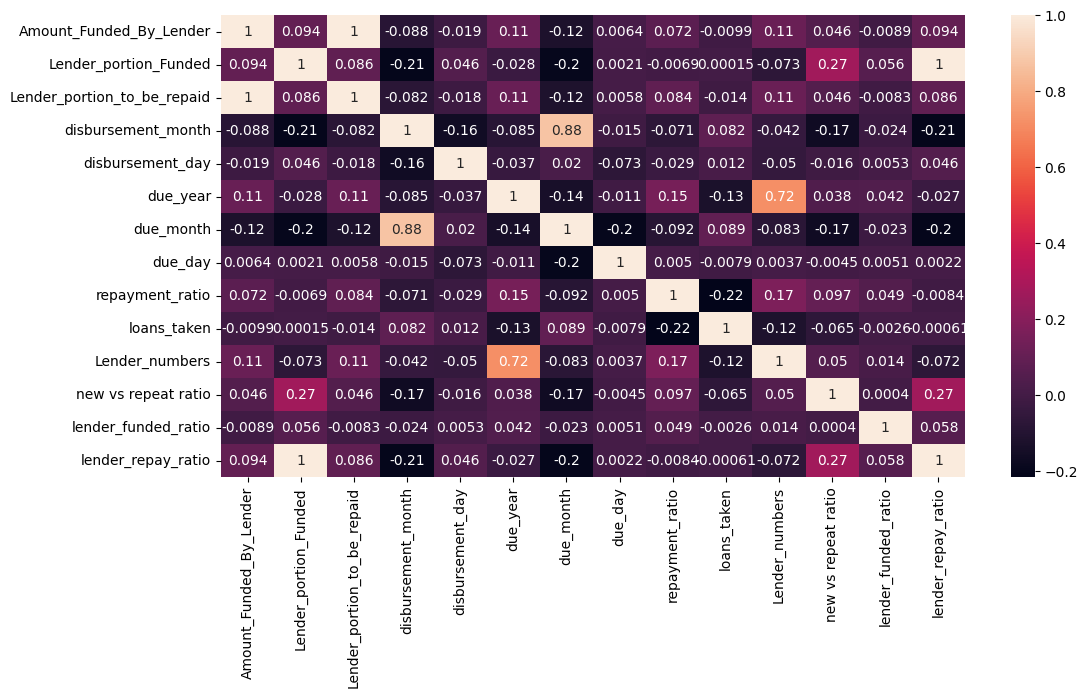

In [82]:
# Final heatmap
nums = predictors.select_dtypes(exclude=['object','category'])
corr = nums.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)
plt.show()

NOTE.Despite the multicolinearity, this combination gave the best score on the public leaderboard so I chose to keep it this way. In hindsight, I should have removed these highly correlated features.

# Baseline model

Starting with a baseline model to see how our model will learn. Will go straight to XGBoost.
In the next challenge, i'll make use of StratifiedGroupKFold, grouping by customer_id to ensure that all customer_ids are in the same group meaning there'll be no leakage.

In [83]:
#One hot encoding training, val and test set
processed_x = pd.get_dummies(predictors.drop(columns=['target']))
processed_y = predictors['target']


processed_test = pd.get_dummies(predictions)

# Aligning the dfs to ensure we have the same columns
final_train, X_test = processed_x.align(processed_test, join='outer', axis=1, fill_value=0)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Looping through each fold
fold_results = []
scaler = StandardScaler()

for fold, (train_index, val_index) in enumerate(skf.split(final_train, processed_y)):
    print(f"Processing Fold {fold+1}...")

    # Train/Validation split for the current fold
    X_train, X_val = final_train.iloc[train_index], final_train.iloc[val_index]
    y_train, y_val = processed_y.iloc[train_index], processed_y.iloc[val_index]
    
# Ensuring y_train and y_val are integers
y_train = y_train.astype('int64')
y_val = y_val.astype('int64')

#Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...


In order to address the class imbalance, I set the class_weights manually which will be passed during the fit. This brought me significantly better results than upsampling using SMOTE.

In [84]:
# Assuming binary classification
class_weights = {0: 1, 1: 3}  # Higher weight for minority class

# Use sample_weight during fitting
sample_weight = y_train.map(class_weights)

Started the tuning with a small grid and then moved to other methods. Medium max depth and min child weight were used to ensure we have no extremes of underfitting/overfitting.

In [85]:
# Hyperparameter tuning
param_grid_x = {
    'learning_rate': [0.01,0.1],
    'max_depth':[5,6],
    'n_estimators': [200, 300],
    'min_child_weight': [5,6]
}


xgbmodel = xgb.XGBClassifier()
xgb_c = RandomizedSearchCV(xgbmodel,param_grid_x,cv=5,scoring='f1')
xgb_c.fit(X_train_scaled,y_train,sample_weight=sample_weight) # Tuning with the weights

print("Tuned XGB Parameters: {}".format(xgb_c.best_params_))
print("Best score is {}".format(xgb_c.best_score_))

xg_params = xgb_c.best_params_

Tuned XGB Parameters: {'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1}
Best score is 0.8745980375161564


After the initial tuning, I made use of Bayesian Optimization and Optuna as well. The Optuna gave me better results on the lb but as expected, both gave better F1 than the simple grid.

In [87]:
# Bayesian Optimization process
def xgb_f1_eval(learning_rate, max_depth, n_estimators, min_child_weight):
    # Convert inputs to integers where required
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    min_child_weight = int(min_child_weight)
    
    # Initialize XGBClassifier with weights for the minority class
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=3  # Adjusting for class imbalance
    )
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict and evaluate F1 score
    y_pred = model.predict(X_val_scaled)
    f1 = f1_score(y_val, y_pred)
    return f1

# Defining the parameter search space
param_bounds = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (5, 10),
    'n_estimators': (100, 500),
    'min_child_weight': (4, 10)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_f1_eval, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Best parameters and F1 score
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_f1_score = optimizer.max['target']

best_params, best_f1_score

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8806    | 0.08116   | 9.754     | 8.392     | 339.5     |
| 2         | 0.8702    | 0.03964   | 5.78      | 4.349     | 446.5     |
| 3         | 0.895     | 0.1242    | 8.54      | 4.124     | 488.0     |
| 4         | 0.8784    | 0.1682    | 6.062     | 5.091     | 173.4     |
| 5         | 0.8721    | 0.06781   | 7.624     | 6.592     | 216.5     |
| 6         | 0.8898    | 0.04621   | 8.321     | 4.59      | 488.7     |
| 7         | 0.881     | 0.04366   | 9.314     | 5.204     | 486.7     |
| 8         | 0.8933    | 0.1133    | 7.08      | 4.376     | 488.2     |
| 9         | 0.8893    | 0.1401    | 6.155     | 4.016     | 486.9     |
| 10        | 0.9004    | 0.1756    | 5.58      | 5.066     | 490.4     |
| 11        | 0.8718    | 0.06541   | 5.302     | 6.015     | 492.2     |
| 12        | 0.8845    | 0.05818   | 

({'learning_rate': 0.09921703479509159,
  'max_depth': 7,
  'min_child_weight': 4,
  'n_estimators': 488},
 0.902970297029703)

In [88]:
# Objective function for Optuna
def objective(trial):
    # Defining the parameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
        'scale_pos_weight': 3,  # Adjust for class imbalance,
        'random_state':42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Initialize the XGBoostClassifier
    model = xgb.XGBClassifier(**params)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val_scaled)
    
    # Evaluate F1 score
    f1 = f1_score(y_val, y_pred)
    return f1

# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Maximize the F1 score
study.optimize(objective, n_trials=30)

# Get the best parameters and score
best_paramss = study.best_params
best_f1_score = study.best_value

print("Best Parameters:", best_paramss)
print("Best F1 Score:", best_f1_score)


[I 2025-01-15 20:23:26,253] A new study created in memory with name: no-name-ff743c2d-bb34-4250-bef5-1b00bc0ba6c7
[I 2025-01-15 20:23:27,264] Trial 0 finished with value: 0.8828125 and parameters: {'learning_rate': 0.147615076876734, 'max_depth': 6, 'n_estimators': 201, 'min_child_weight': 6}. Best is trial 0 with value: 0.8828125.
[I 2025-01-15 20:23:28,477] Trial 1 finished with value: 0.882703777335984 and parameters: {'learning_rate': 0.1952578324052241, 'max_depth': 5, 'n_estimators': 293, 'min_child_weight': 5}. Best is trial 0 with value: 0.8828125.
[I 2025-01-15 20:23:29,908] Trial 2 finished with value: 0.8804780876494024 and parameters: {'learning_rate': 0.1916231813158689, 'max_depth': 7, 'n_estimators': 319, 'min_child_weight': 7}. Best is trial 0 with value: 0.8828125.
[I 2025-01-15 20:23:31,097] Trial 3 finished with value: 0.8853754940711462 and parameters: {'learning_rate': 0.14749083562502693, 'max_depth': 5, 'n_estimators': 318, 'min_child_weight': 6}. Best is trial 3

Best Parameters: {'learning_rate': 0.12936738050036584, 'max_depth': 8, 'n_estimators': 411, 'min_child_weight': 5}
Best F1 Score: 0.8972332015810277


In [90]:
#XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, **best_params) # Trying Bayesian params

xgb_model.fit(X_train_scaled,y_train,sample_weight=sample_weight)
y_pred = xgb_model.predict(X_test_scaled)

#Matrix of the train data
training_set = xgb_model.predict(X_train_scaled)
print('Trained data matrix:',confusion_matrix(y_train,training_set))
print('Training set:',accuracy_score(y_train,training_set))
print(classification_report(y_train,training_set))

#Matrix of val data
val_set = xgb_model.predict(X_val_scaled)
print('Validation data matrix:',confusion_matrix(y_val,val_set))
print('Validation set:',accuracy_score(y_val,val_set))
print(classification_report(y_val,val_set))

Trained data matrix: [[53916     1]
 [    0  1007]]
Training set: 0.9999817930230864
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53917
           1       1.00      1.00      1.00      1007

    accuracy                           1.00     54924
   macro avg       1.00      1.00      1.00     54924
weighted avg       1.00      1.00      1.00     54924

Validation data matrix: [[13454    25]
 [   28   223]]
Validation set: 0.9961398397669338
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.90      0.89      0.89       251

    accuracy                           1.00     13730
   macro avg       0.95      0.94      0.95     13730
weighted avg       1.00      1.00      1.00     13730



These results show a good balance between classes which is good to see considering the class imbalance. Just need to ensure that there was no data leakage anywhere.

Below shows that the CV score for F1 was 0.86. Given our standard deviation is less than 0.2 of our mean, we can conclude that the model's performance is stable.

In [91]:
# Define the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Using F1 score
f1_scorer = make_scorer(f1_score)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=kfold, scoring=f1_scorer)

# Output the scores
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of F1 Scores: {cv_scores.std():.4f}")

Cross-Validation F1 Scores: [0.85714286 0.87468031 0.88778055 0.86082474 0.83636364]
Mean F1 Score: 0.8634
Standard Deviation of F1 Scores: 0.0173


Adjusting the decision boundary but didn't get any difference.

In [92]:
# Adjusted threshold
# Predict probabilities
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold
threshold = 0.45
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)



In [93]:
# Predict probabilities
y_pred_proba_val = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Adjust threshold
threshold = 0.45
y_pred_adjusted_val = (y_pred_proba_val >= threshold).astype(int)

# # Evaluate performance
print('Validation data matrix:',confusion_matrix(y_val,y_pred_adjusted_val))
print('Validation set:',accuracy_score(y_val,y_pred_adjusted_val))
print(classification_report(y_val, y_pred_adjusted_val))

Validation data matrix: [[13449    30]
 [   25   226]]
Validation set: 0.9959941733430444
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.88      0.90      0.89       251

    accuracy                           1.00     13730
   macro avg       0.94      0.95      0.94     13730
weighted avg       1.00      1.00      1.00     13730



# Feature Importance

In [94]:
# Feature importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)

repayment_ratio                 0.18
loan_type_Type_23               0.18
Duration category_Medium-term   0.14
due_year                        0.07
loan_type_Type_11               0.06
                                ... 
loan_type_Type_17               0.00
loan_type_Type_18               0.00
loan_type_Type_19               0.00
loan_type_Type_20               0.00
weekday/weekend_Weekend         0.00
Length: 72, dtype: float32


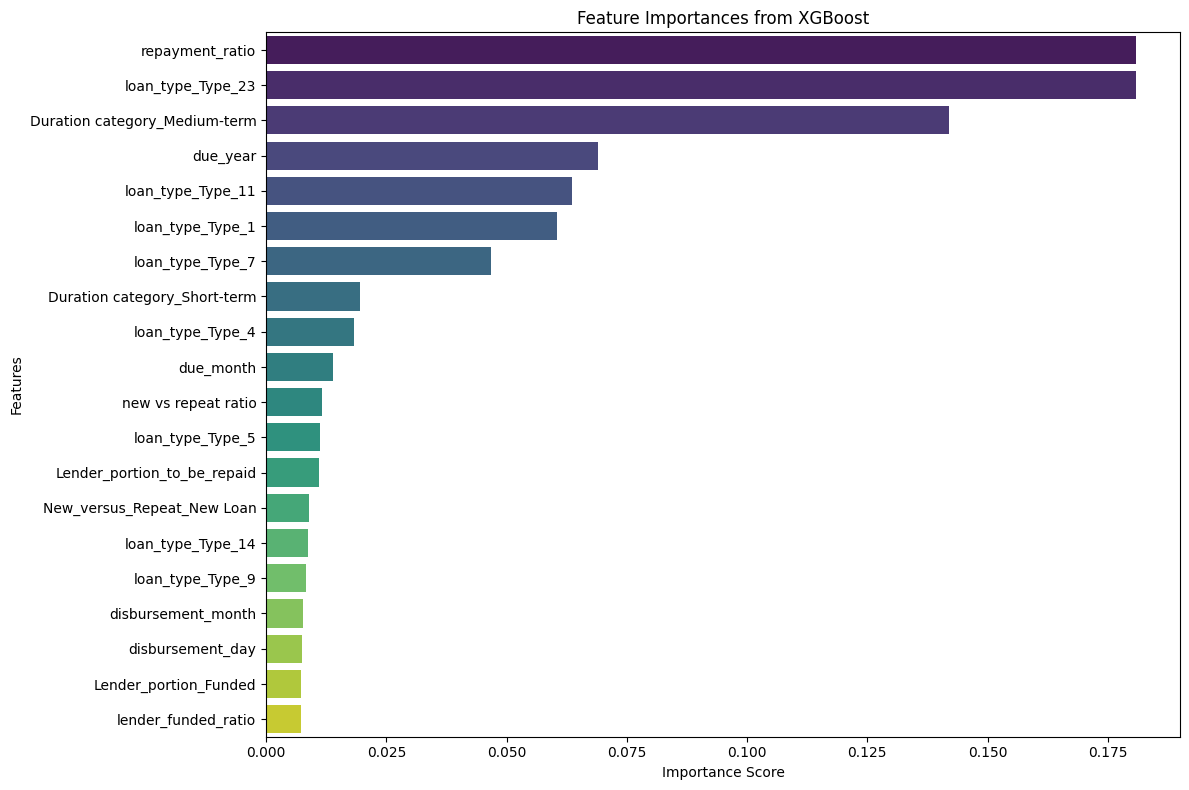

In [95]:
# Plotting the feature importances
plt.figure(figsize=(12, 8))  
sns.barplot(x=feature_importances.values[:20], y=feature_importances.index[:20], palette="viridis")  # Top 20 features
plt.title("Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()  
plt.show()

# Tuning and Ensemble

To boost the results, I incorporated an ensemble approach adding Catboost and LGBM classifiers, and then using Stacking/Voting to make the predictions. In this situation the Voting Classifier produced better lb results. Did a simpler param tune for both of these but in future might also run Optuna on them to maximise accuracy.

In [100]:
# Params for catboost
param_grid_r = {
    'iterations': [100],               # Number of boosting iterations. Any higher and processing time is too long
    'learning_rate': [0.03, 0.15],           
    'depth': [6, 8],                        
    'l2_leaf_reg': [3, 7],                  # L2 regularization strength
    'bagging_temperature': [3, 5],          
}

catboost = CatBoostClassifier()
cat = RandomizedSearchCV(catboost,param_grid_r,n_iter=5,cv=5,scoring='f1')
cat.fit(X_train_scaled,y_train,sample_weight=sample_weight)

print("Tuned RF Parameters: {}".format(cat.best_params_))
print("Best score is {}".format(cat.best_score_))

cat_params = cat.best_params_

0:	learn: 0.6182165	total: 188ms	remaining: 18.6s
1:	learn: 0.5518930	total: 201ms	remaining: 9.83s
2:	learn: 0.4944031	total: 215ms	remaining: 6.95s
3:	learn: 0.4307018	total: 229ms	remaining: 5.49s
4:	learn: 0.3864691	total: 242ms	remaining: 4.59s
5:	learn: 0.3415913	total: 254ms	remaining: 3.99s
6:	learn: 0.3053922	total: 266ms	remaining: 3.53s
7:	learn: 0.2760386	total: 278ms	remaining: 3.19s
8:	learn: 0.2478417	total: 290ms	remaining: 2.93s
9:	learn: 0.2181054	total: 301ms	remaining: 2.71s
10:	learn: 0.1984617	total: 312ms	remaining: 2.52s
11:	learn: 0.1794455	total: 324ms	remaining: 2.37s
12:	learn: 0.1615115	total: 335ms	remaining: 2.24s
13:	learn: 0.1487033	total: 346ms	remaining: 2.13s
14:	learn: 0.1338203	total: 358ms	remaining: 2.03s
15:	learn: 0.1232976	total: 369ms	remaining: 1.94s
16:	learn: 0.1135175	total: 380ms	remaining: 1.85s
17:	learn: 0.1044248	total: 391ms	remaining: 1.78s
18:	learn: 0.1007601	total: 404ms	remaining: 1.72s
19:	learn: 0.0959505	total: 415ms	remaini

In [101]:
# Lightgbm params
param_grid_l = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [4, 5, 6, 7],  
    'n_estimators': [100, 200, 300, 500],  
    'min_child_weight': [3, 5, 10],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0]  
}

lgbmodel = LGBMClassifier()
lgb_c = RandomizedSearchCV(lgbmodel,param_grid_x,cv=5,scoring='f1')
lgb_c.fit(X_train_scaled,y_train,sample_weight=sample_weight)

print("Tuned LGB Parameters: {}".format(lgb_c.best_params_))
print("Best score is {}".format(lgb_c.best_score_))

lg_params = lgb_c.best_params_

[LightGBM] [Info] Number of positive: 806, number of negative: 43133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 43939, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053083 -> initscore=-2.881348
[LightGBM] [Info] Start training from score -2.881348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [102]:
# My models
xgb_modell = xgb.XGBClassifier(**best_params)  
cat_model = CatBoostClassifier(**cat_params, random_state=42)
lgb_model = LGBMClassifier(**lg_params)  # LightGBM model

# Fit models individually
xgb_modell.fit(X_train_scaled, y_train,sample_weight=sample_weight)
cat_model.fit(X_train_scaled, y_train,sample_weight=sample_weight)
lgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weight)

# Evaluate individual models
for model, name in zip([xgb_modell, cat_model, lgb_model], ['XGBoost', 'Catboost','Light GBM']):
    y_val_pred = model.predict(X_val_scaled)
    print(f"{name} F1 Score: {f1_score(y_val, y_val_pred):.4f}")


0:	learn: 0.3380741	total: 19.4ms	remaining: 1.92s
1:	learn: 0.1748170	total: 34.1ms	remaining: 1.67s
2:	learn: 0.1043542	total: 49.8ms	remaining: 1.61s
3:	learn: 0.0753229	total: 65.1ms	remaining: 1.56s
4:	learn: 0.0588256	total: 81.8ms	remaining: 1.55s
5:	learn: 0.0486305	total: 96.7ms	remaining: 1.51s
6:	learn: 0.0457173	total: 111ms	remaining: 1.47s
7:	learn: 0.0409334	total: 125ms	remaining: 1.44s
8:	learn: 0.0379040	total: 139ms	remaining: 1.41s
9:	learn: 0.0348803	total: 154ms	remaining: 1.39s
10:	learn: 0.0334125	total: 168ms	remaining: 1.36s
11:	learn: 0.0325217	total: 182ms	remaining: 1.34s
12:	learn: 0.0308841	total: 197ms	remaining: 1.32s
13:	learn: 0.0299949	total: 212ms	remaining: 1.3s
14:	learn: 0.0282020	total: 229ms	remaining: 1.3s
15:	learn: 0.0269015	total: 245ms	remaining: 1.28s
16:	learn: 0.0257173	total: 262ms	remaining: 1.28s
17:	learn: 0.0248363	total: 277ms	remaining: 1.26s
18:	learn: 0.0243131	total: 293ms	remaining: 1.25s
19:	learn: 0.0235472	total: 308ms	rem

In [103]:
# VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_modell), ('cat', cat_model), ('lgb', lgb_model)],
    voting='soft',
    weights=[0.4, 0.3, 0.3]# Use 'soft' for probabilities, weighted XGBoost a bit higher
)
voting_clf.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred = voting_clf.predict(X_val_scaled)
print(f"VotingClassifier F1 Score: {f1_score(y_val, y_val_pred):.4f}")


0:	learn: 0.3012951	total: 22.2ms	remaining: 2.2s
1:	learn: 0.1470528	total: 36.7ms	remaining: 1.8s
2:	learn: 0.0798135	total: 52.1ms	remaining: 1.68s
3:	learn: 0.0497780	total: 67.4ms	remaining: 1.62s
4:	learn: 0.0362886	total: 82.1ms	remaining: 1.56s
5:	learn: 0.0287557	total: 96.4ms	remaining: 1.51s
6:	learn: 0.0236956	total: 111ms	remaining: 1.47s
7:	learn: 0.0219815	total: 125ms	remaining: 1.44s
8:	learn: 0.0206651	total: 140ms	remaining: 1.41s
9:	learn: 0.0198086	total: 154ms	remaining: 1.39s
10:	learn: 0.0192824	total: 167ms	remaining: 1.35s
11:	learn: 0.0180679	total: 182ms	remaining: 1.34s
12:	learn: 0.0178860	total: 196ms	remaining: 1.31s
13:	learn: 0.0172693	total: 211ms	remaining: 1.29s
14:	learn: 0.0169653	total: 225ms	remaining: 1.27s
15:	learn: 0.0158846	total: 241ms	remaining: 1.27s
16:	learn: 0.0151566	total: 256ms	remaining: 1.25s
17:	learn: 0.0147885	total: 269ms	remaining: 1.23s
18:	learn: 0.0146333	total: 282ms	remaining: 1.2s
19:	learn: 0.0143392	total: 295ms	rema

In [104]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# Define the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Using F1 score
f1_scorer = make_scorer(f1_score)

# Perform cross-validation
cv_scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=kfold, scoring=f1_scorer)

# Output the scores
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of F1 Scores: {cv_scores.std():.4f}")

0:	learn: 0.3019435	total: 13.6ms	remaining: 1.34s
1:	learn: 0.1467059	total: 28.3ms	remaining: 1.39s
2:	learn: 0.0796430	total: 40.8ms	remaining: 1.32s
3:	learn: 0.0517536	total: 52.6ms	remaining: 1.26s
4:	learn: 0.0403083	total: 64.5ms	remaining: 1.22s
5:	learn: 0.0322151	total: 76.4ms	remaining: 1.2s
6:	learn: 0.0275573	total: 87.6ms	remaining: 1.16s
7:	learn: 0.0244437	total: 99ms	remaining: 1.14s
8:	learn: 0.0225519	total: 110ms	remaining: 1.11s
9:	learn: 0.0202291	total: 121ms	remaining: 1.08s
10:	learn: 0.0192070	total: 132ms	remaining: 1.07s
11:	learn: 0.0173431	total: 143ms	remaining: 1.05s
12:	learn: 0.0171655	total: 154ms	remaining: 1.03s
13:	learn: 0.0163390	total: 166ms	remaining: 1.02s
14:	learn: 0.0157719	total: 178ms	remaining: 1.01s
15:	learn: 0.0155038	total: 189ms	remaining: 991ms
16:	learn: 0.0151845	total: 200ms	remaining: 975ms
17:	learn: 0.0150387	total: 211ms	remaining: 961ms
18:	learn: 0.0149389	total: 221ms	remaining: 943ms
19:	learn: 0.0141775	total: 234ms	re

Stacking didn't give me good results in this occasion.

In [105]:
# # StackingClassifier
# stacking_clf = StackingClassifier(
#     estimators=[('xgb', xgb_modell), ('cat', cat_model), ('lgb', lgb_model)],
#     final_estimator=xgb.XGBClassifier(random_state=42),
#     cv=5
# )
# stacking_clf.fit(X_train_scaled, y_train)

# # Evaluate on validation set
# y_val_pred = stacking_clf.predict(X_val_scaled)
# print(f"StackingClassifier F1 Score: {f1_score(y_val, y_val_pred):.4f}")


In [106]:
from sklearn.metrics import precision_recall_curve
# Predict probabilities
y_val_probs = voting_clf.predict_proba(X_val_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Predict with adjusted threshold
y_val_pred = (y_val_probs >= optimal_threshold).astype(int)
print(f"Adjusted F1 Score: {f1_score(y_val, y_val_pred):.4f}")


Optimal Threshold: 0.3484
Adjusted F1 Score: 0.8984


In [107]:
y_test_pred = voting_clf.predict(X_test_scaled)
# Predict probabilities
y_pred_probab = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold
threshold = optimal_threshold
y_pred_adjusted = (y_pred_probab >= threshold).astype(int)

In [108]:
# Predict probabilities
y_pred_proba_valx = voting_clf.predict_proba(X_val_scaled)[:, 1]

# Adjust threshold
threshold = optimal_threshold
y_pred_adjusted_val = (y_pred_proba_valx >= threshold).astype(int)

# # Evaluate performance
print('Validation data matrix:',confusion_matrix(y_val,y_pred_adjusted_val))
print('Validation set:',accuracy_score(y_val,y_pred_adjusted_val))
print(classification_report(y_val, y_pred_adjusted_val))

Validation data matrix: [[13448    31]
 [   21   230]]
Validation set: 0.9962126729788784
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.88      0.92      0.90       251

    accuracy                           1.00     13730
   macro avg       0.94      0.96      0.95     13730
weighted avg       1.00      1.00      1.00     13730



# Submission

In [110]:
test['ID']

0        ID_269404226088267278
1        ID_255356300042267278
2        ID_257026243764267278
3        ID_264617299409267278
4        ID_247613296713267278
                 ...          
18589    ID_297596365331297183
18590    ID_259715231897267278
18591    ID_296701364008297183
18592    ID_268271242864267278
18593    ID_248929241821267278
Name: ID, Length: 18594, dtype: object

In [111]:
test.Target = y_pred_adjusted

# Create submission DataFrame
submission = pd.DataFrame({"ID": test["ID"],
                           "Target": test.Target})
submission

,ID,Target
0,ID_269404226088267278,0
1,ID_255356300042267278,0
2,ID_257026243764267278,0
3,ID_264617299409267278,0
4,ID_247613296713267278,0
...,...,...
18589,ID_297596365331297183,0
18590,ID_259715231897267278,0
18591,ID_296701364008297183,0
18592,ID_268271242864267278,0


In [113]:
# Create submission csv file csv file
submission.to_csv('adjusted_submission.csv', index = False)
